In [1]:
import os
import numpy as np
import pandas as pd
import tqdm
import scipy
import random
from cycler import cycler
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

import torch
from torch import nn
from torch.utils.data import DataLoader

import optuna
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search.basic_variant import BasicVariantGenerator

import snntorch as snn
from snntorch import surrogate, utils, functional as SF

import warnings
warnings.filterwarnings("ignore")

from params import params_cae, params_snn, params_train
import utils_ext
import network
import sae
import train_eval
from train_eval import train_fn, evaluate


torch.manual_seed(22)

%reload_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
plt.rcParams.update({
    'axes.labelsize': 30.0,
    'grid.alpha': 0.6,
    'legend.framealpha': 0.6,
    "text.usetex": True,
    "font.family": "serif",
    'figure.figsize': [12,6],
    "font.size": 30,
    "hatch.linewidth": 0.0,
    "hatch.color": (0,0,0,0.0),
    "axes.prop_cycle": cycler(color=sns.color_palette("tab10"))
    })

### Load train, validation and test dataset and create Data Loader

In [3]:
N_WIN = 232
N_RANGE_BINS = 10
WIN_LEN = 64

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

train_dataset = torch.load('data/train_dataset.pt')#, map_location=torch.device(device))
val_dataset = torch.load('data/val_dataset.pt')#, map_location=torch.device(device))
test_dataset = torch.load('data/test_dataset.pt')#, map_location=torch.device(device))

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_loader =  DataLoader(val_dataset, batch_size=batch)
test_loader = DataLoader(test_dataset, batch_size=1)

x = next(iter(train_loader))[0]

print(f"\nShape of each element in the dataloader: {x.shape}")

Using cuda device

Shape of each element in the dataloader: torch.Size([8, 2, 232, 10, 64])


In [6]:
print(f"Number of elements in train set: {len(train_dataset)}.")
print(f"Number of elements in valid set:  {len(val_dataset)}.")
print(f"Number of elements in test set:   {len(test_dataset)}.")

Number of elements in train set: 2355.
Number of elements in valid set:  383.
Number of elements in test set:   383.


### Plot some examples

In [6]:
ACTIVITIES = [
    "WALKING",
    "RUNNING",
    "SITTING",
    "HANDS",
]
class_enc = {a:np.eye(len(ACTIVITIES))[i] for i, a in enumerate(ACTIVITIES)}
class_dec = {tuple(v): k for k, v in class_enc.items()}
class_dec

{(1.0, 0.0, 0.0, 0.0): 'WALKING',
 (0.0, 1.0, 0.0, 0.0): 'RUNNING',
 (0.0, 0.0, 1.0, 0.0): 'SITTING',
 (0.0, 0.0, 0.0, 1.0): 'HANDS'}

In [4]:
ACTIVITIES = [
    "WALKING",
    "RUNNING",
    "SITTING",
    "HANDS",
]
class_enc = {a:[i] for i, a in enumerate(ACTIVITIES)}
class_dec = {int(v[0]): k for k, v in class_enc.items()}
class_dec

{0: 'WALKING', 1: 'RUNNING', 2: 'SITTING', 3: 'HANDS'}

#### Some Plots

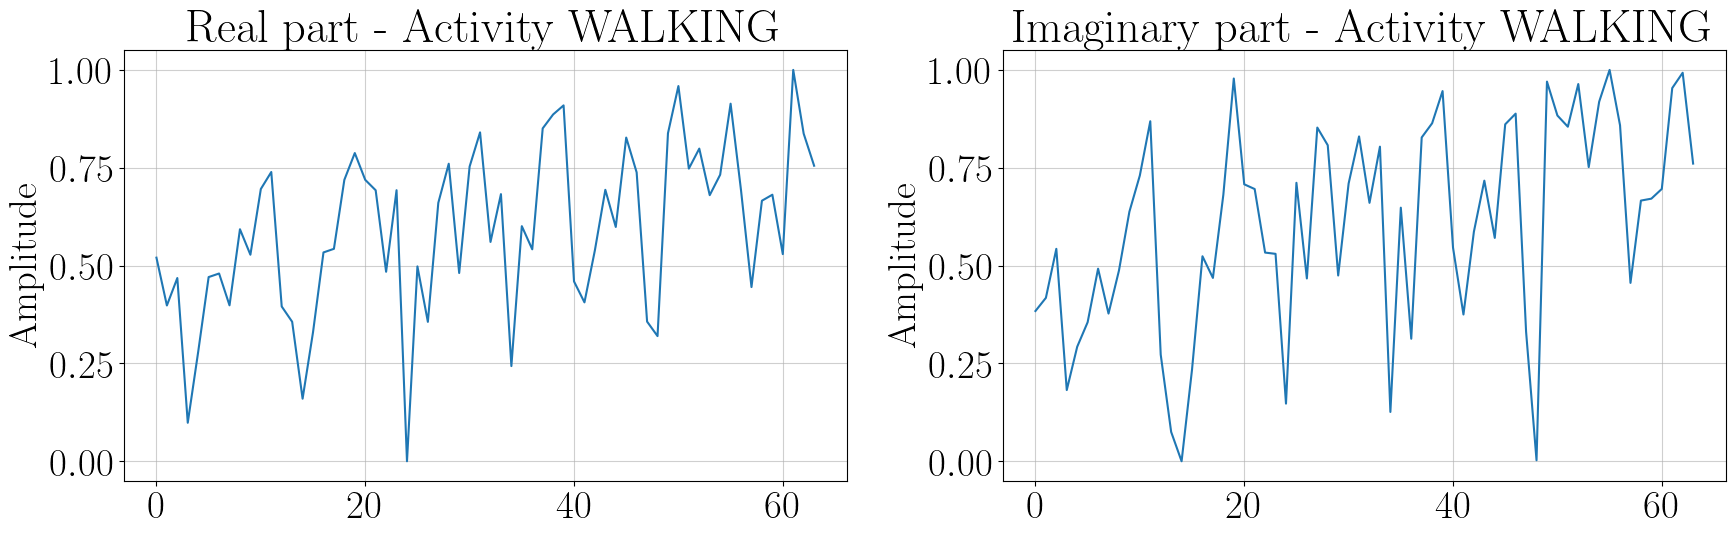

CIR shape: torch.Size([2, 232, 10, 64])


In [6]:
i = np.random.randint(0, len(train_dataset))
X, Y = train_dataset[i][0], train_dataset[i][2]

fig, ax = plt.subplots(1, 2, figsize=(18,6))

plt.subplot(121)
plt.plot(X[0,0,0,:].cpu().numpy())
plt.ylabel('Amplitude')
plt.title(f"Real part - Activity {class_dec[int(Y)]}")
plt.grid()

plt.subplot(122)
plt.plot(X[0,0,1,:].cpu().numpy())
plt.ylabel('Amplitude')
plt.title(f"Imaginary part - Activity {class_dec[int(Y)]}")
plt.grid()
plt.tight_layout()

#plt.savefig('Signal_example1.png')
plt.show()

print(f"CIR shape: {X.shape}")

The CIR has shape ($2$, $N$, $R$, $K$), where:

- $2$ is the number of convolutional channels (one for the real part of the CIR, one for the imaginary part);
- $N$ is the number of windows, in this case: $W=232$;
- $R$ is the number of range bins, in this case: $R=10$;
- $K$ is the length of each windows, in this case: $K=64$.

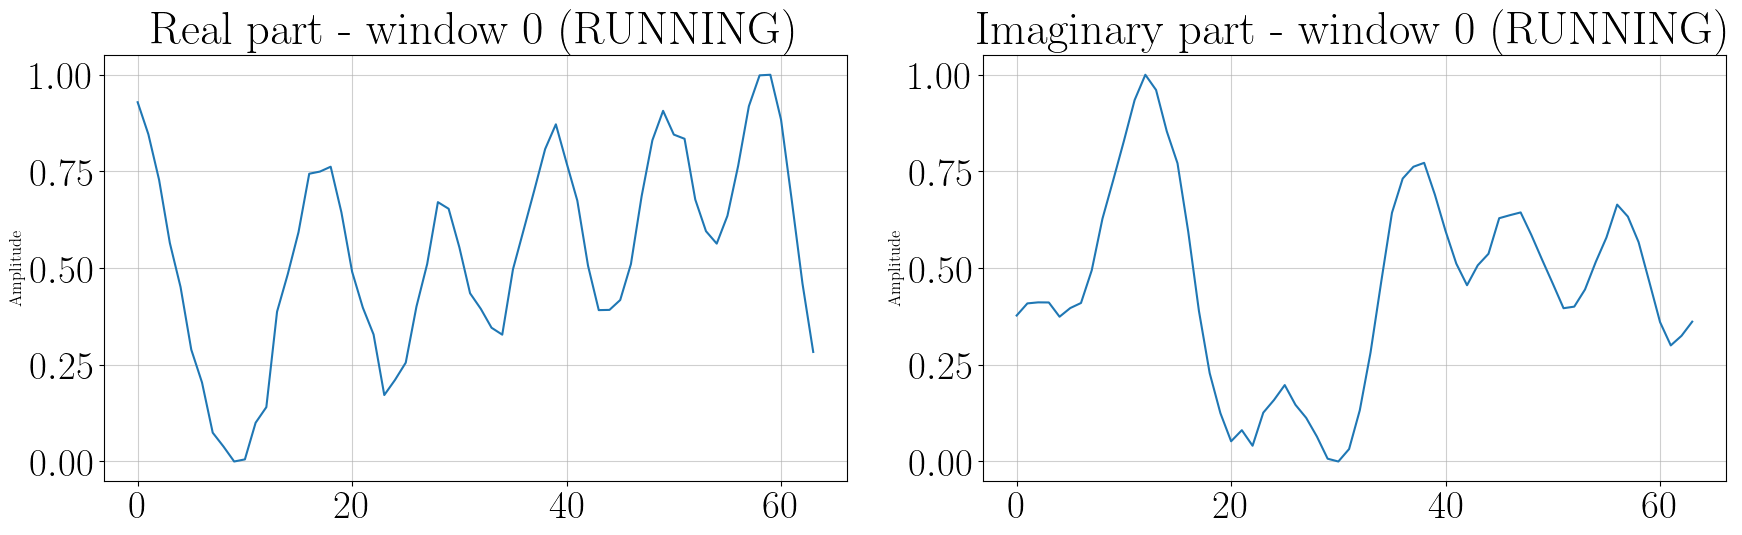

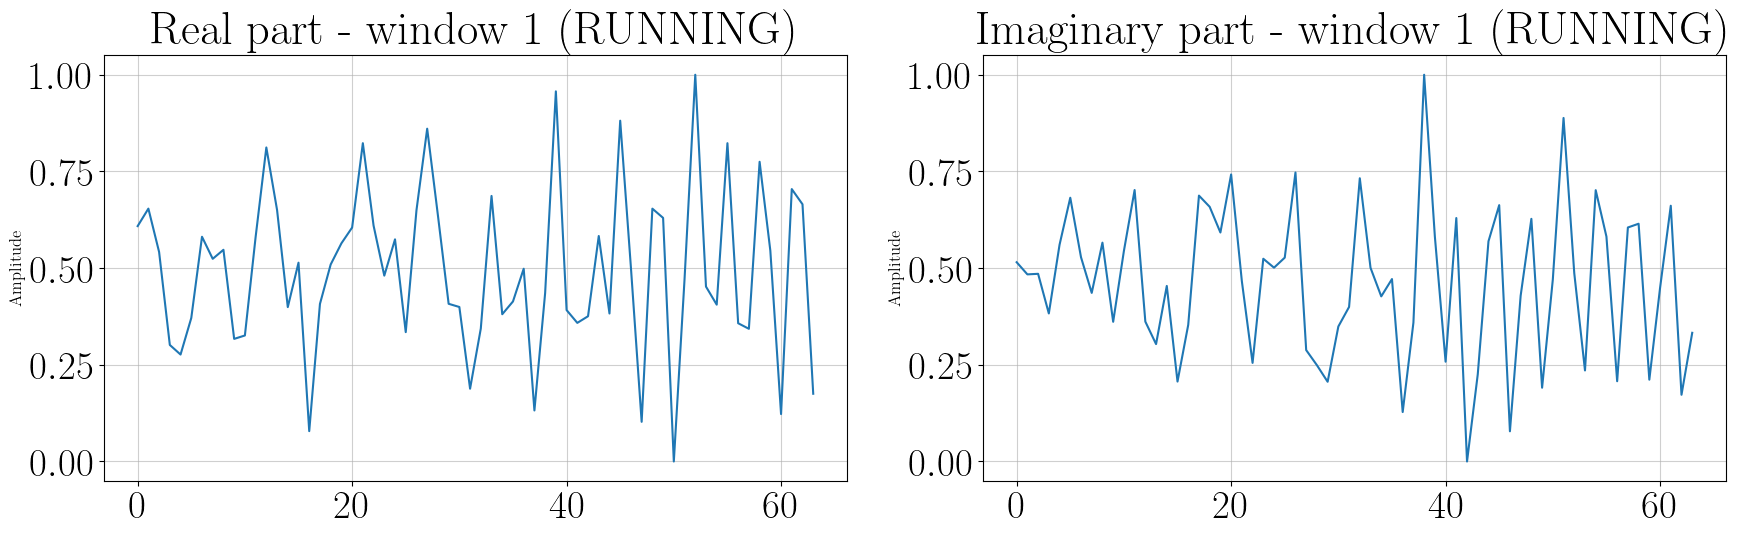

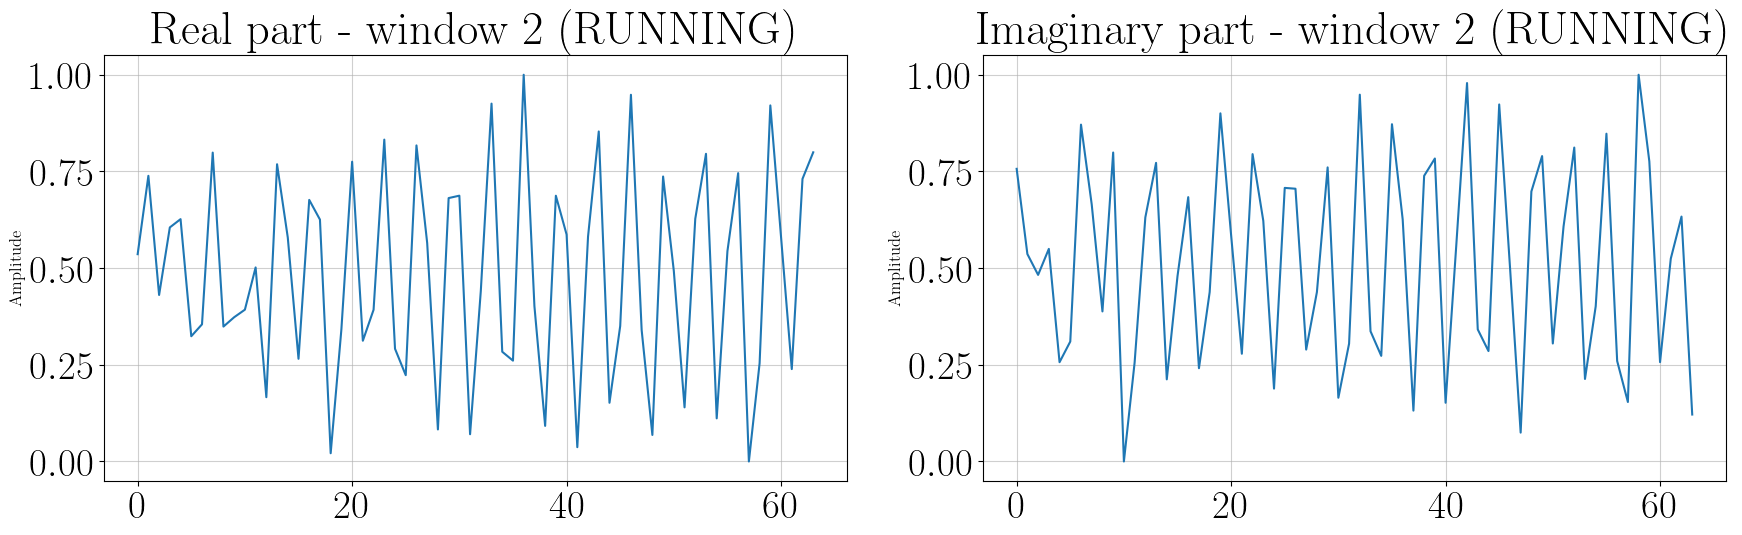

In [7]:
i = np.random.randint(0, len(train_dataset))
X, Y = train_dataset[i][0],train_dataset[i][-1]

for w in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(18,6))

    plt.subplot(121)
    plt.plot(X[0, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(f"Real part - window {w} ({class_dec[int(Y)]})")
    plt.grid()

    plt.subplot(122)
    plt.plot(X[1, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude',  fontsize=12)
    plt.title(f"Imaginary part - window {w} ({class_dec[int(Y)]})")
    plt.grid()
    plt.tight_layout()

    #plt.savefig('Signal_example1.png')
    plt.show()

In [167]:
for batch, X in enumerate(train_loader):
    print(X[0].shape)
    print(X[2].shape)
    break

torch.Size([32, 2, 232, 10, 64])
torch.Size([32, 1])


#### Input correlation

In [8]:
corr_input = []

for X, _, _ in tqdm.tqdm(train_dataset):

    for w in range(X.shape[1]):
        for b in range(X.shape[2]):

            corr_input.append(np.corrcoef(X[0][w][b], X[1][w][b])[0,1])

  0%|          | 0/935 [00:00<?, ?it/s]

100%|██████████| 935/935 [02:13<00:00,  7.01it/s]


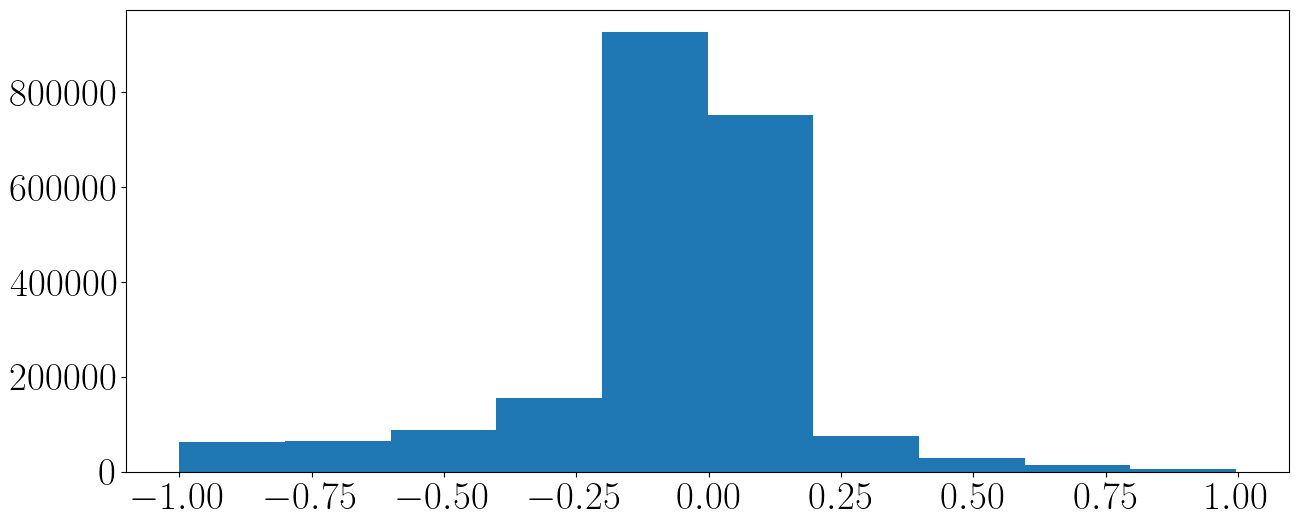

In [9]:
plt.hist(corr_input)
plt.show()

### Model definition

In [9]:
class LSE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(LSE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.snn(encoded)  
        return encoded, decoded, clss

## Hyperparameter optimization

### 1. # Conv. layers in the CAE

In [ ]:
val_mse_layers = []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

# CAE with 2 layers
autoencoder = network.cae_2(
                            tau = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], padding = params_cae['padding']
                            ).to(device)

net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                    model = net, 
                                                    train = train_loader, valid = val_loader,
                                                    loss_fn_cae = params_cae['loss_fn'], 
                                                    out_dec = params_snn['output_dec'],
                                                    optimizer = optimizer, 
                                                    acc_steps = params_train['acc_steps'],
                                                     alpha = params_train['alpha'], 
                                                    beta = params_train['beta'], 
                                                    Lambda = params_train['lambda_reg'], 
                                                    epochs = params_train['epochs'], 
                                                    patience = params_train['patience'], 
                                                    path = None)

val_mse_layers.append(np.mean(val_loss))

autoencoder = autoencoder.cpu()
net = net.cpu()

del autoencoder, optimizer, net
torch.cuda.empty_cache()

# CAE with 3 layers
autoencoder = network.cae_3(
                            theta = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], padding = params_cae['padding']
                            ).to(device)
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss1, val_loss1, train_acc1, val_acc1, cae_loss1, snn_loss1 = train(
                                                        model = net, 
                                                        train = train_loader, valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
val_mse_layers.append(np.mean(val_loss1))

In [17]:
model_parameters = filter(lambda p: p.requires_grad, autoencoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

1932

In [ ]:
print(torch.cuda.memory_summary())

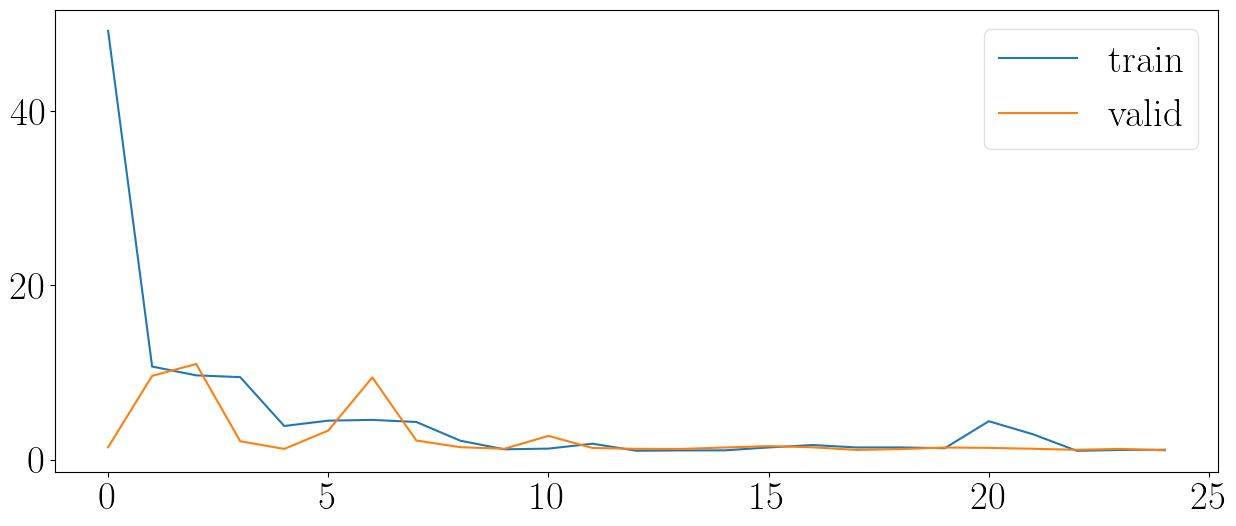

In [13]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='valid')
#plt.xticks(np.arange(epochs), labels=np.arange(epochs)+1)
plt.legend()
plt.show()

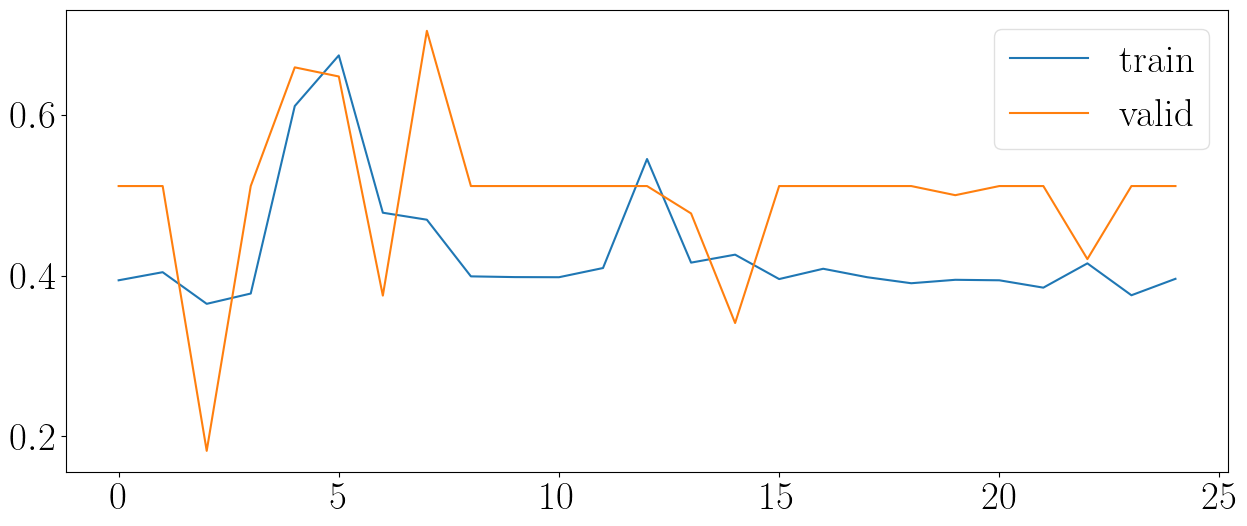

In [14]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='valid')
#plt.xticks(np.arange(epochs), labels=np.arange(epochs)+1)
plt.legend()
plt.show()

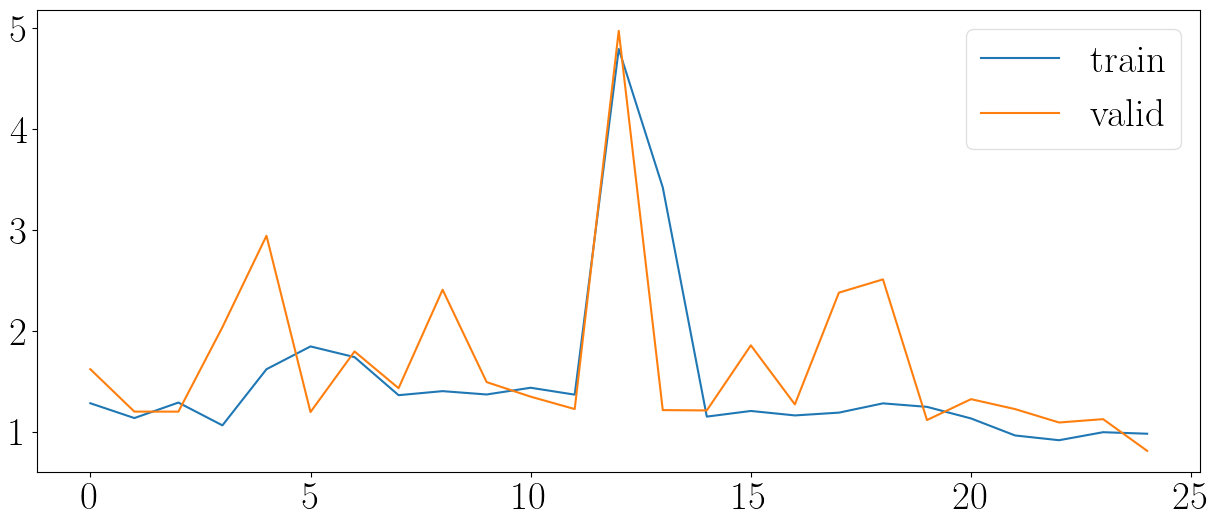

In [15]:
plt.plot(train_loss1, label='train')
plt.plot(val_loss1, label='valid')
#plt.xticks(np.arange(epochs), labels=np.arange(epochs)+1)
plt.legend()
plt.show()

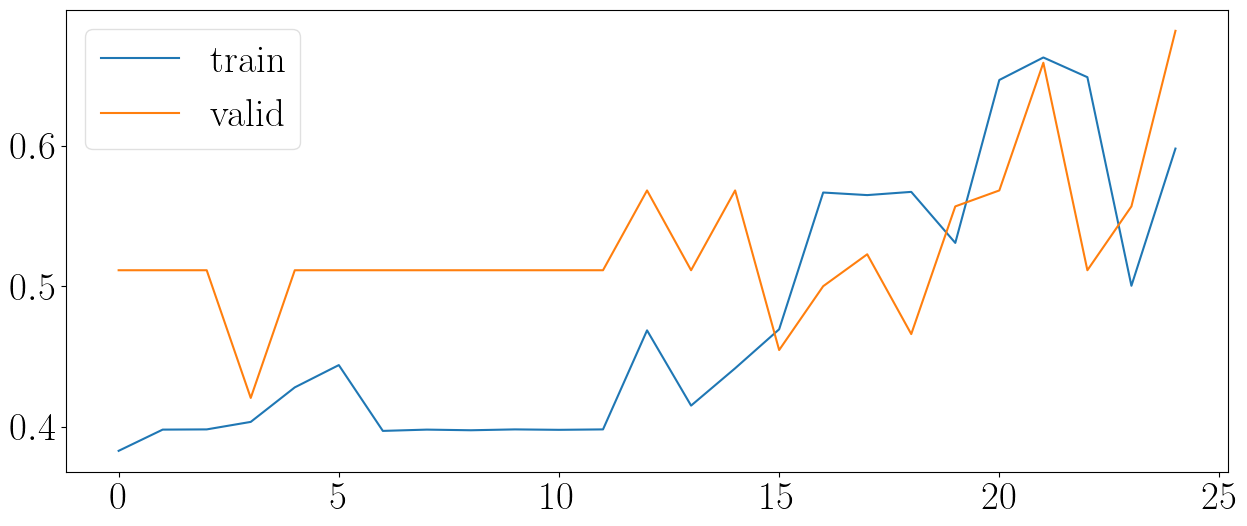

In [16]:
plt.plot(train_acc1, label='train')
plt.plot(val_acc1, label='valid')
#plt.xticks(np.arange(epochs), labels=np.arange(epochs)+1)
plt.legend()
plt.show()

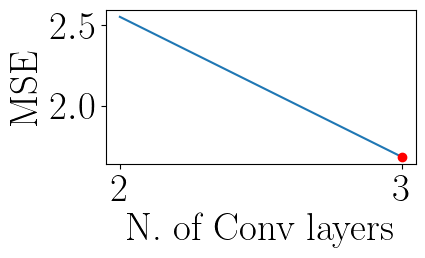

In [25]:
ind_min_nl = np.argmin(val_mse_layers)
plt.figure(figsize=(4,2))
plt.plot(val_mse_layers)
plt.plot(ind_min_nl, val_mse_layers[ind_min_nl], marker='o', color='red')
plt.xticks([0,1], ['2', '3'])
plt.xlabel('N. of Conv layers')
plt.ylabel('MSE')
plt.show()

### 2. Number of channels

In [ ]:
channels = [[64,32], [128,64], [256,128]]
val_mse_channels = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [],  []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for ch in channels:
    autoencoder = network.cae_3(
                            tau = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], padding = params_cae['padding']
                            ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_channels.append(np.mean(val_loss))

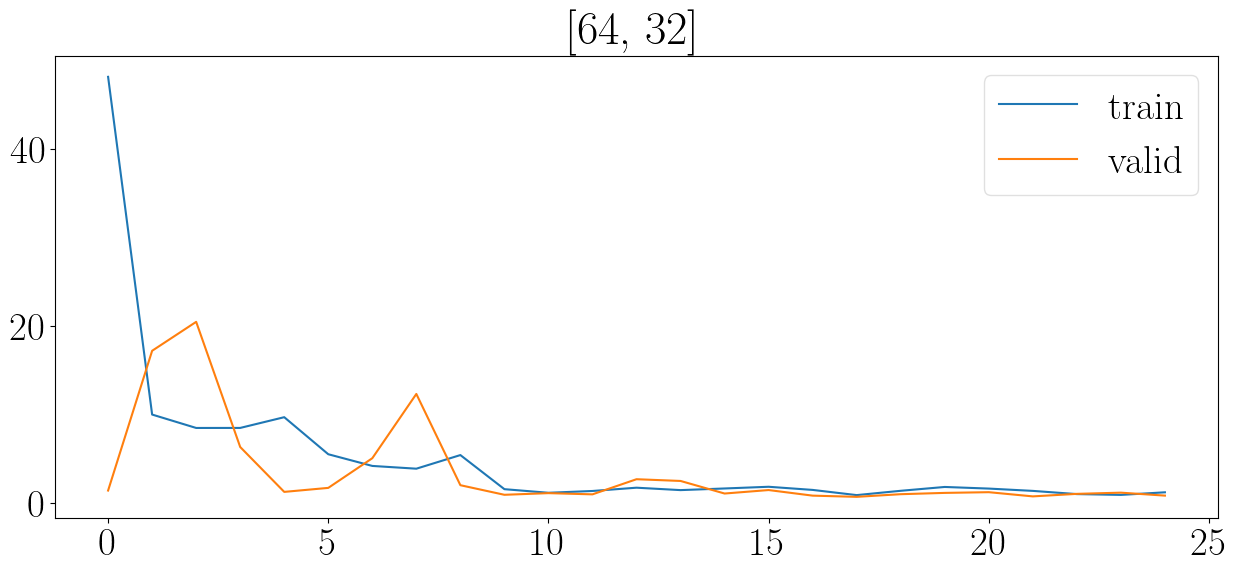

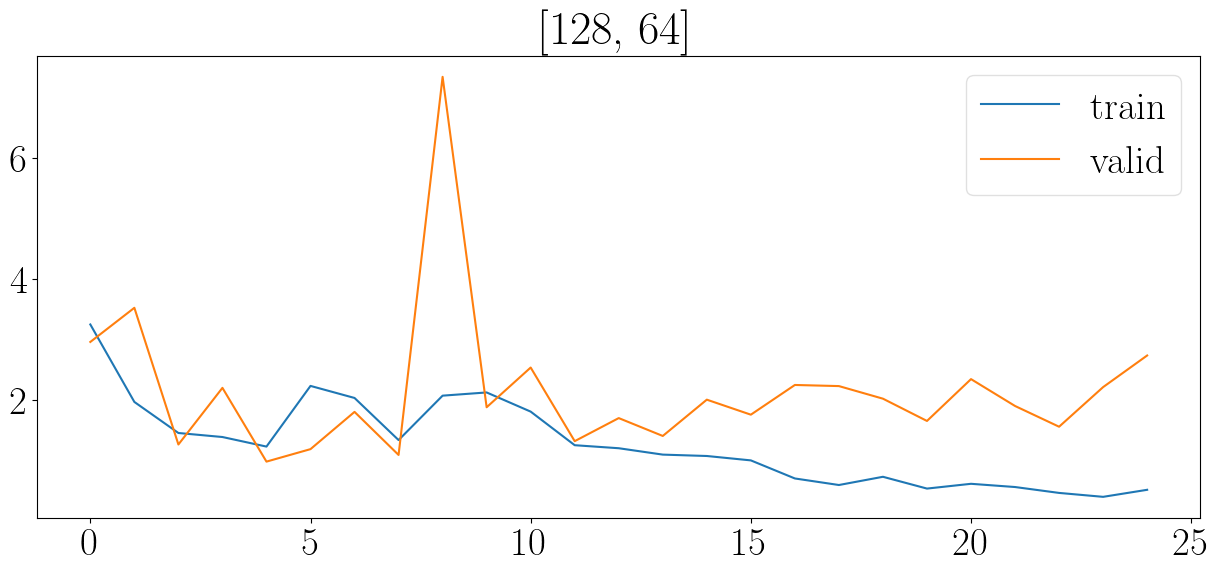

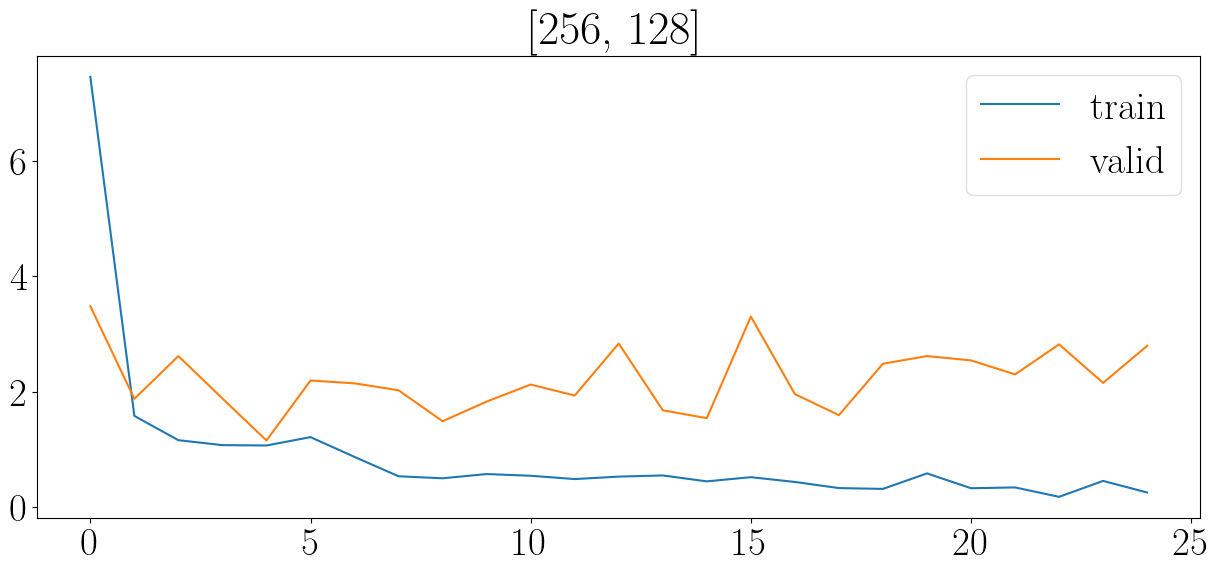

In [17]:
for i in range(len(train_losses)):
    plt.plot(train_losses[i], label='train')
    plt.plot(val_losses[i], label='valid')
    plt.title(str(channels[i]))
    plt.legend()
    plt.show()

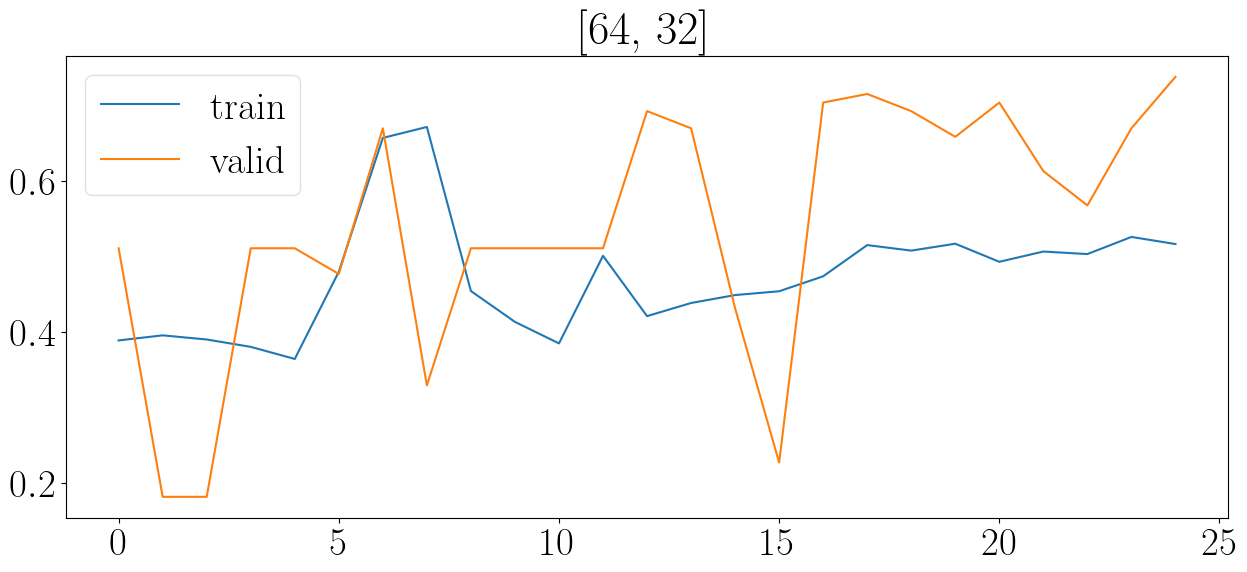

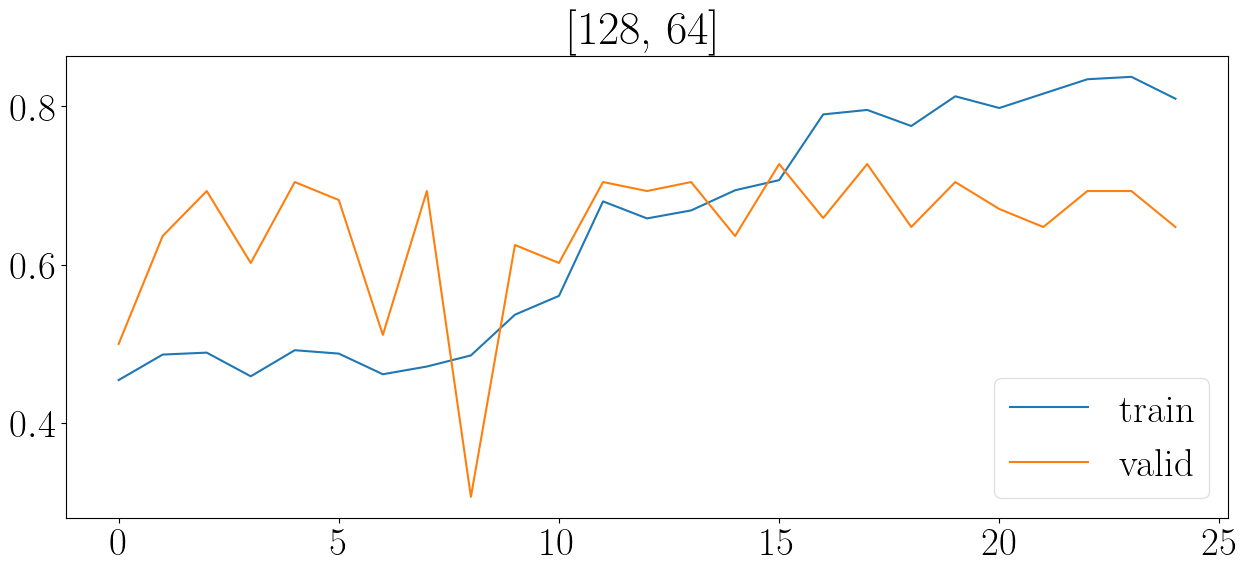

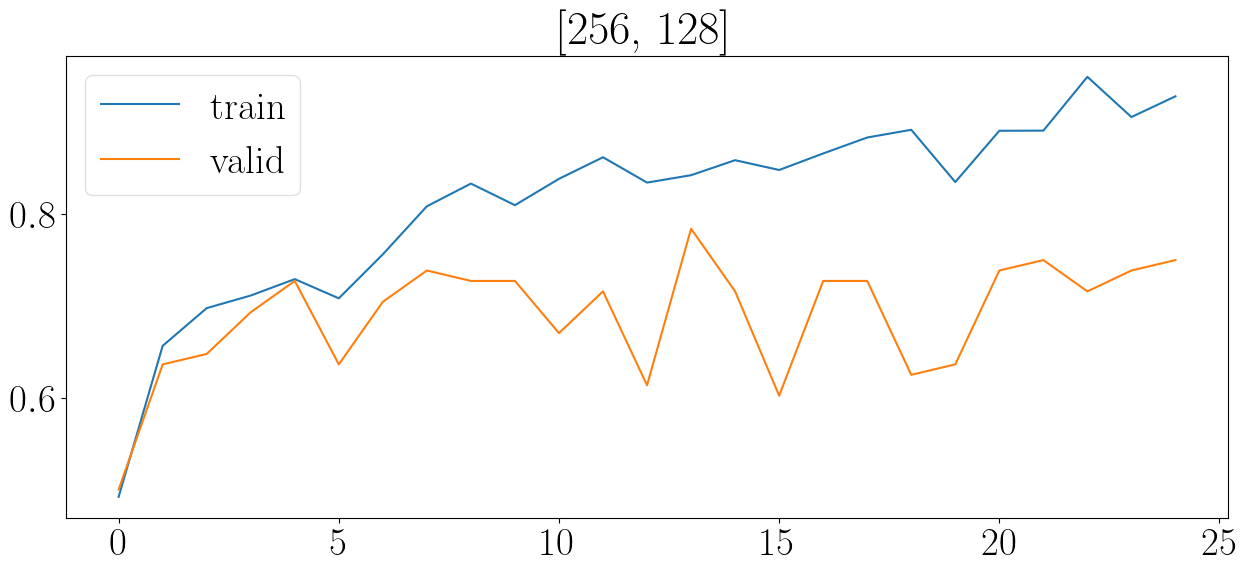

In [18]:
for i in range(len(train_accs)):
    plt.plot(train_accs[i], label='train')
    plt.plot(val_accs[i], label='valid')
    plt.title(str(channels[i]))
    plt.legend()
    plt.show()

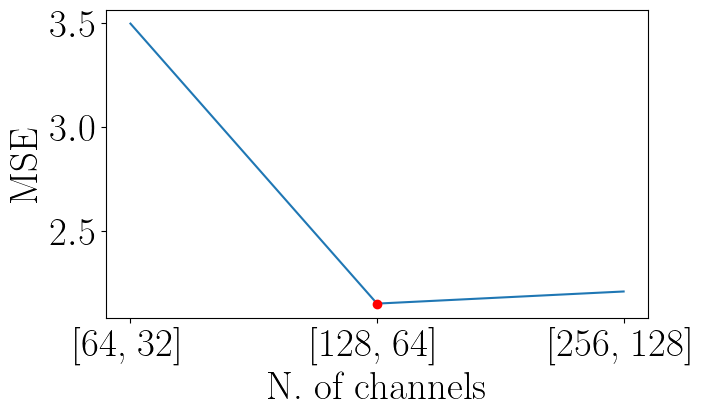

In [13]:
ind_min_ch = np.argmin(val_mse_channels)
plt.figure(figsize=(7,4))
plt.plot(val_mse_channels)
plt.plot(ind_min_ch, val_mse_channels[ind_min_ch], marker='o', color='red')
plt.xticks(np.arange(len(channels)), channels)
plt.xlabel('N. of channels')
plt.ylabel('MSE')
plt.show()

In [7]:
channels_ = []
if channels[ind_min_ch][0]==64:
    channels_ = [[64, 64], [128, 64], [64, 128]]

elif channels[ind_min_ch][0]==128:
    channels_ = [[64, 128], [128, 64], [128, 128]]

else:
    channels_ = [[128, 256], [256, 128], [256, 256]]

channels_

[[64, 128], [128, 64], [128, 128]]

In [ ]:
channels = [[64,128], [128,64], [128,128]]
val_mse_channels = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [],  []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for ch in channels:
    autoencoder = network.cae_3(
                            theta = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], padding = params_cae['padding']
                            ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_eval.train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_channels.append(np.mean(val_loss))

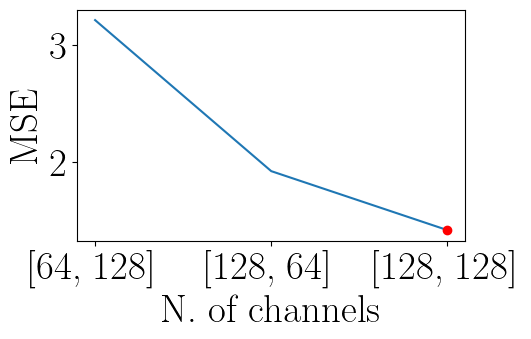

In [23]:
ind_min_ch = np.argmin(val_mse_channels)
plt.figure(figsize=(5,3))
plt.plot(val_mse_channels)
plt.plot(ind_min_ch, val_mse_channels[ind_min_ch], marker='o', color='red')
plt.xticks(np.arange(len(channels)), channels)
plt.xlabel('N. of channels')
plt.ylabel('MSE')
plt.show()

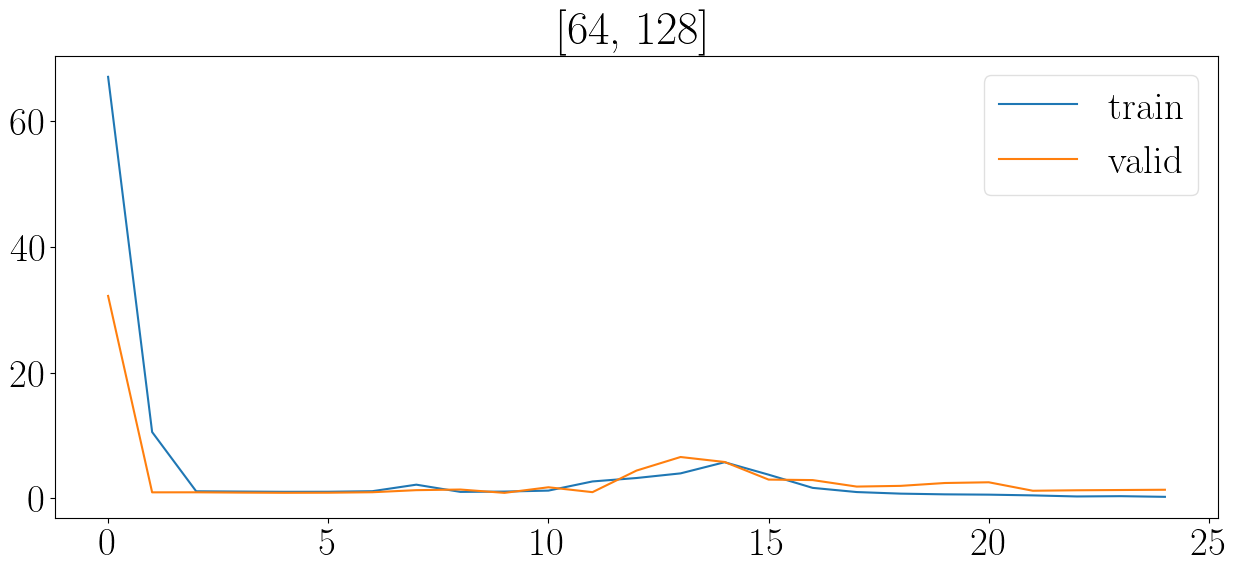

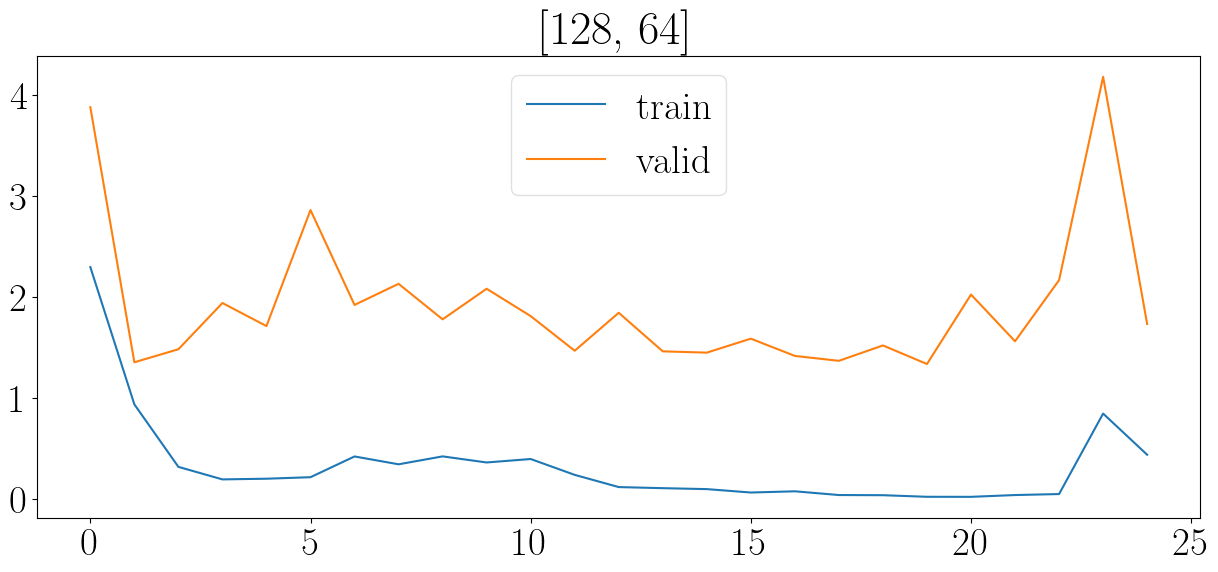

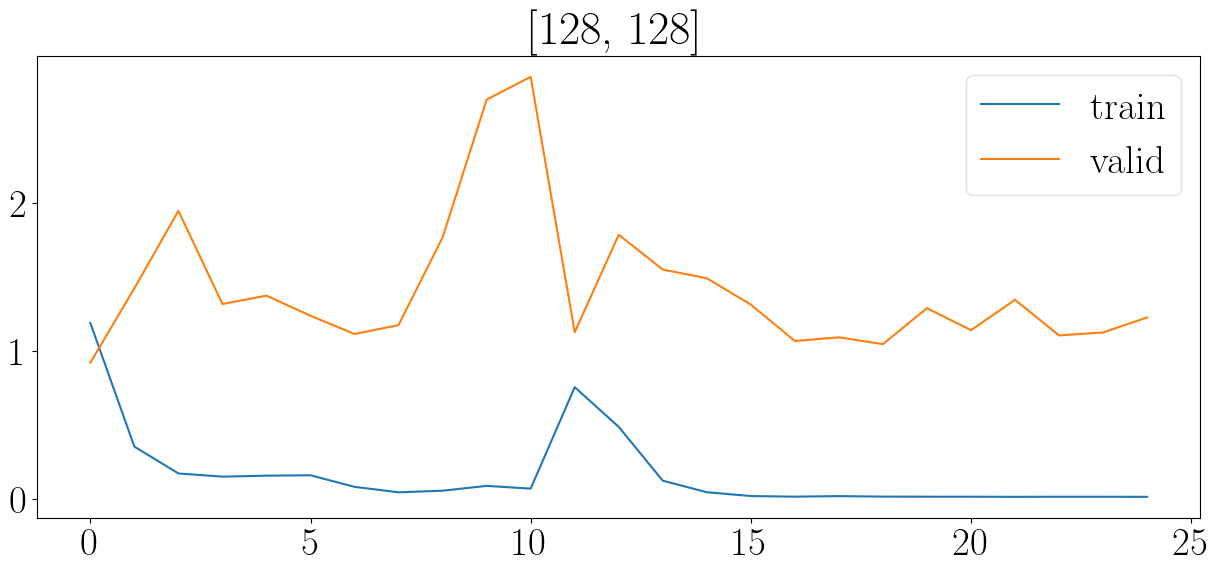

In [25]:
for i in range(len(train_losses)):
    plt.plot(train_losses[i], label='train')
    plt.plot(val_losses[i], label='valid')
    plt.title(str(channels[i]))
    plt.legend()
    plt.show()

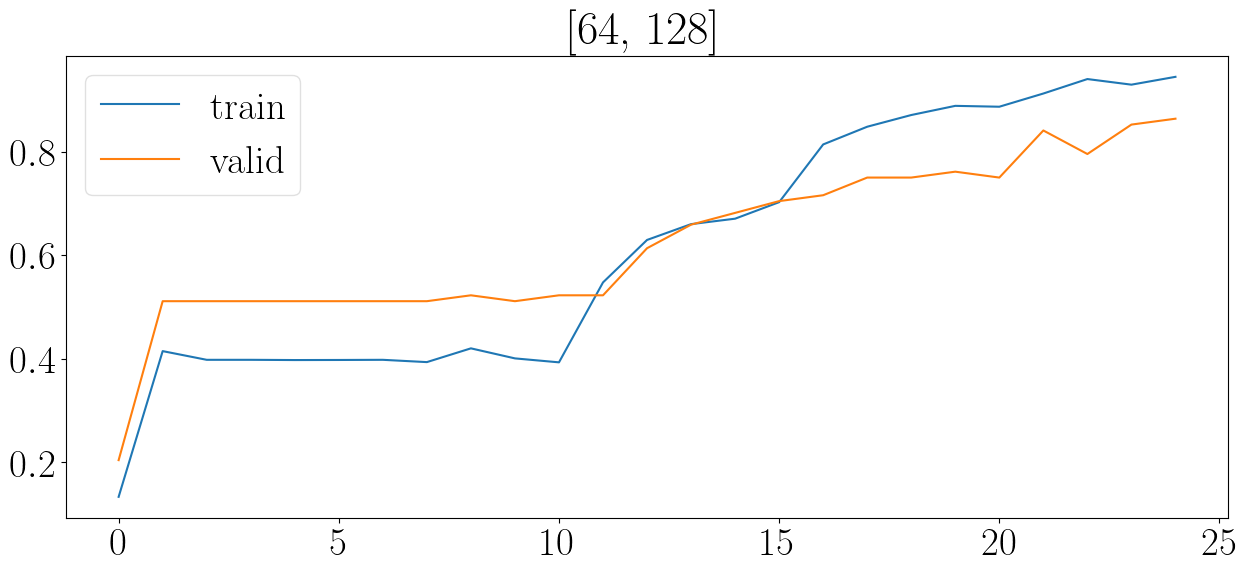

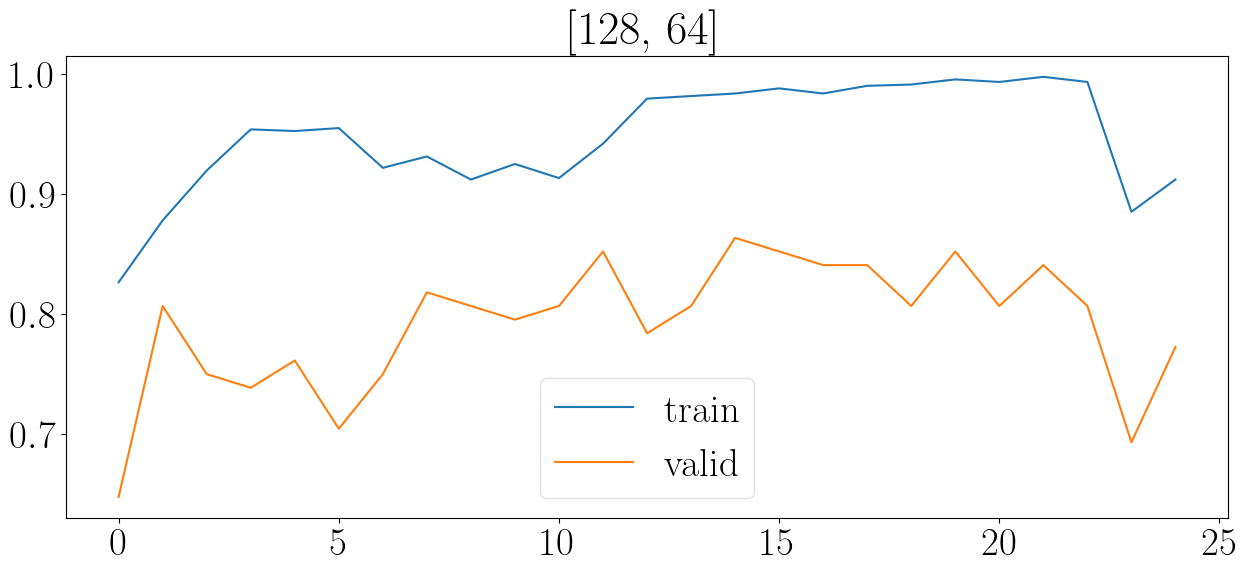

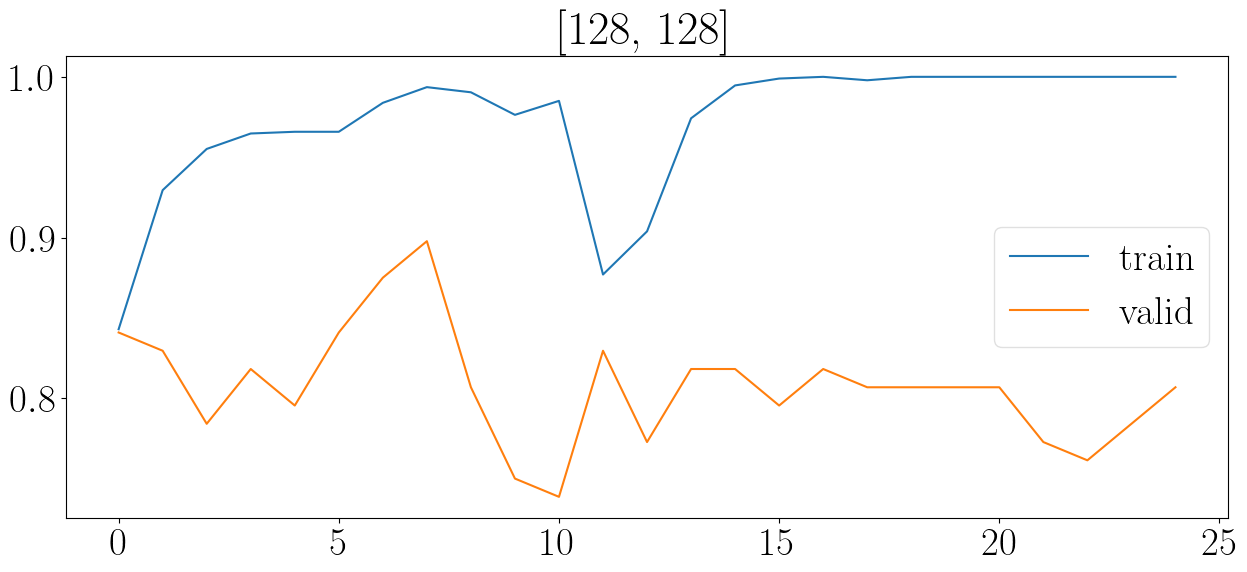

In [24]:
for i in range(len(train_accs)):
    plt.plot(train_accs[i], label='train')
    plt.plot(val_accs[i], label='valid')
    plt.title(str(channels[i]))
    plt.legend()
    plt.show()

### 3. Kernel size

In [11]:
autoencoder = autoencoder.cpu()
net = net.cpu()

del autoencoder, optimizer, net
torch.cuda.empty_cache()

In [ ]:
kernel_dic = {(1,1,3): [0,0,1], (1,1,5): [0,0,2], (1,1,7): [0,0,3], (1,1,9): [0,0,4]}
val_mse_kernel = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params.params_snn['hidden_layers'], 
                    n_classes = params.params_snn['num_classes'], 
                    surr_grad = params.params_snn['surrogate_grad'],
                    learn_thr = params.params_snn['learn_thr'], 
                    learn_beta = params.params_snn['learn_beta']
                    ).to(device)

for kernel, pad in kernel_dic.items():
    autoencoder = network.cae_3(
                            tau = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = kernel, 
                            stride = params_cae['stride'], padding = pad
                            ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_kernel.append(np.mean(val_loss))

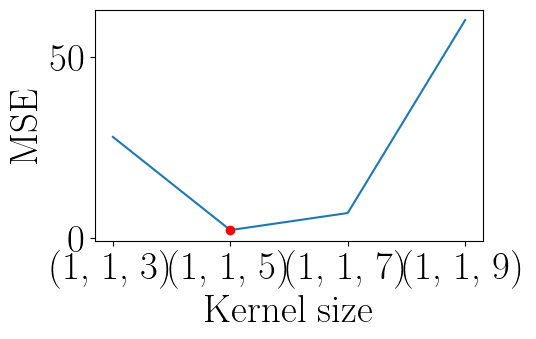

In [16]:
ind_min_ker = np.argmin(val_mse_kernel)
plt.figure(figsize=(5,3))
plt.plot(val_mse_kernel)
plt.plot(ind_min_ker, val_mse_kernel[ind_min_ker], marker='o', color='red')
plt.xticks(np.arange(len(kernel_dic)), kernel_dic.keys())
plt.xlabel('Kernel size')
plt.ylabel('MSE')
plt.show()

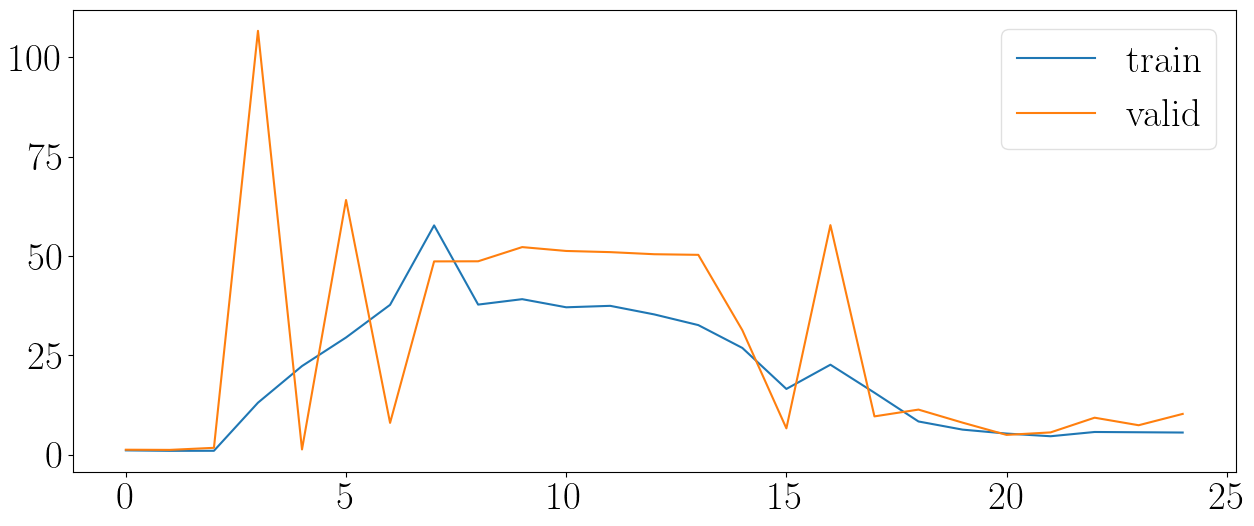

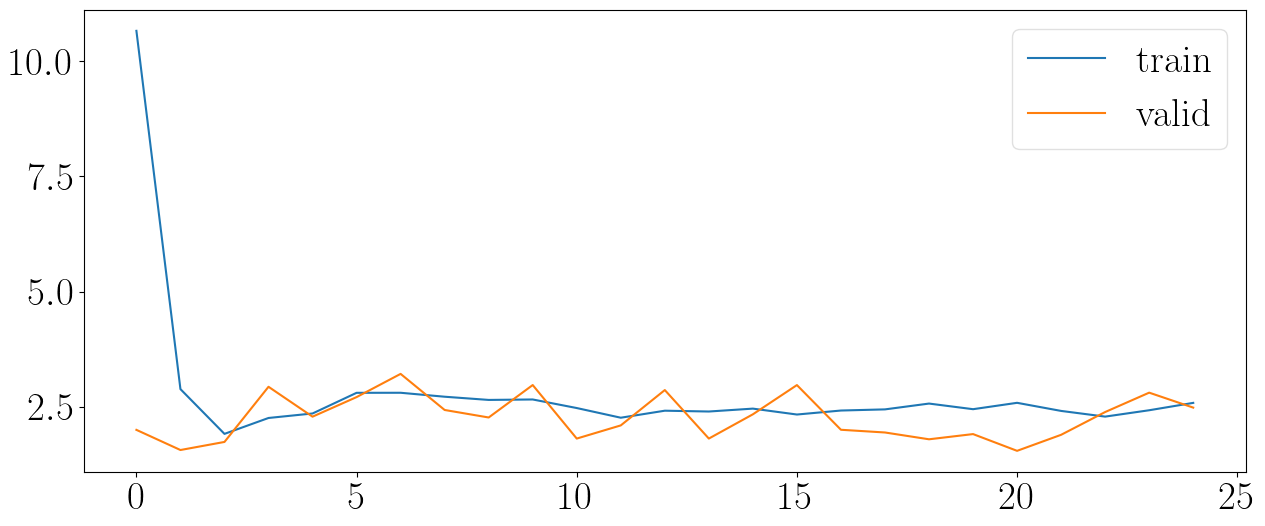

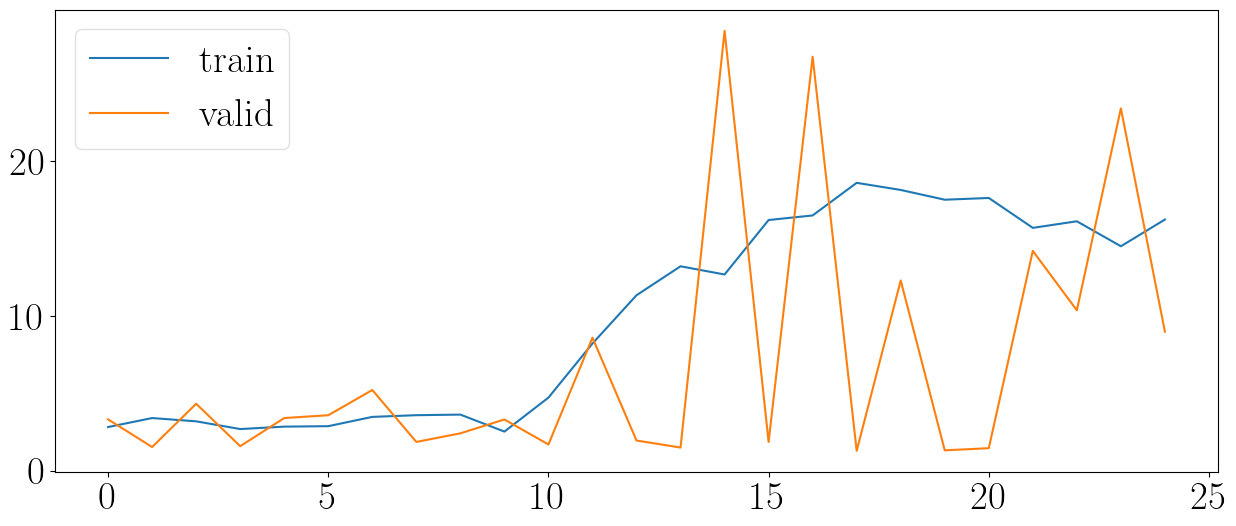

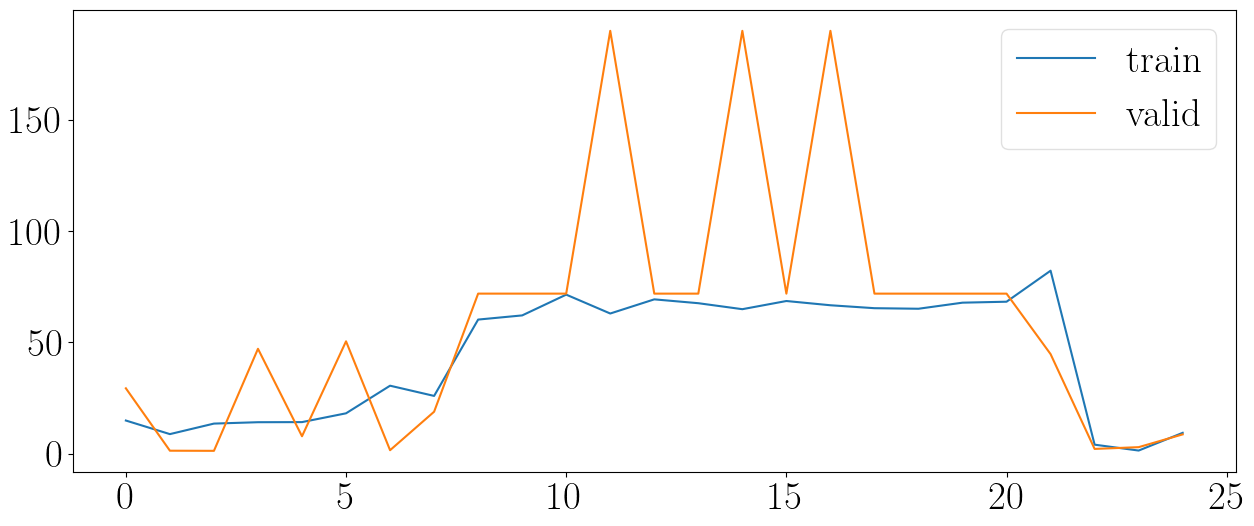

In [18]:
for i in range(len(train_losses)):
    plt.plot(train_losses[i], label='train')
    plt.plot(val_losses[i], label='valid')
    #plt.title(str(channels[i]))
    plt.legend()
    plt.show()

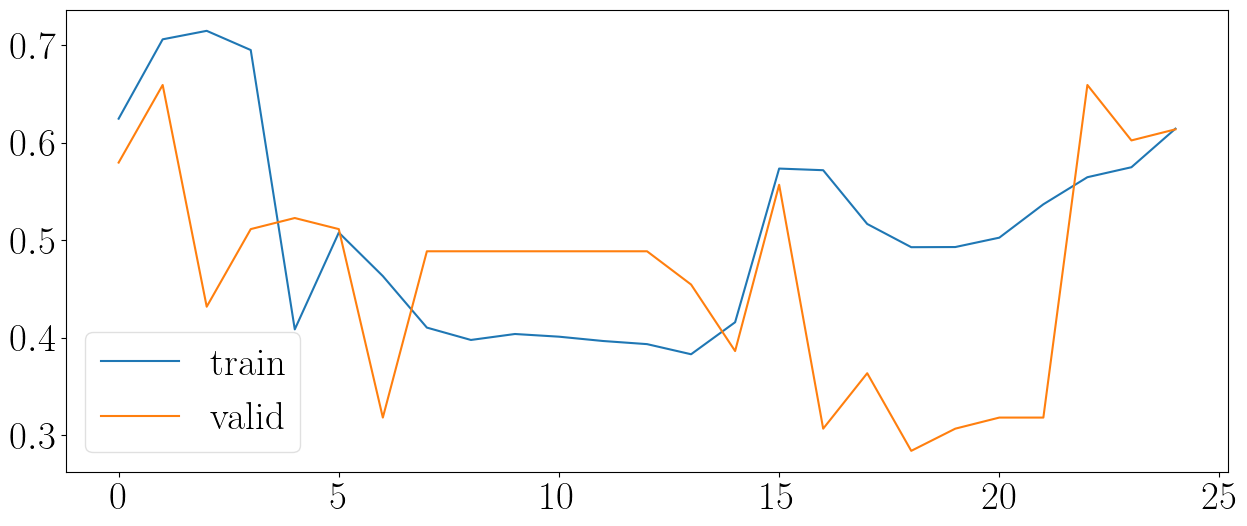

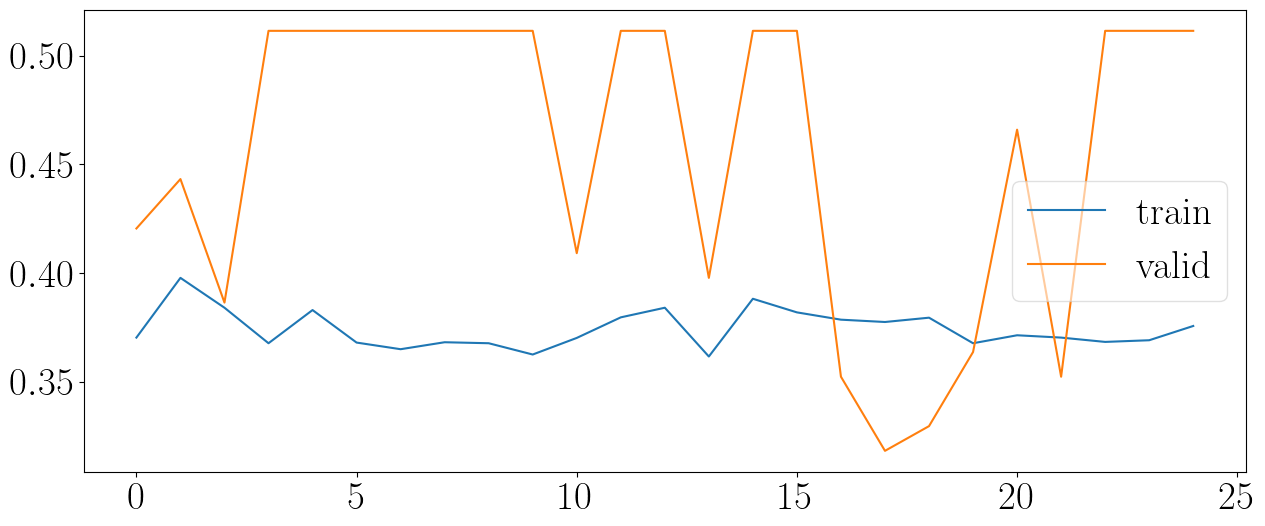

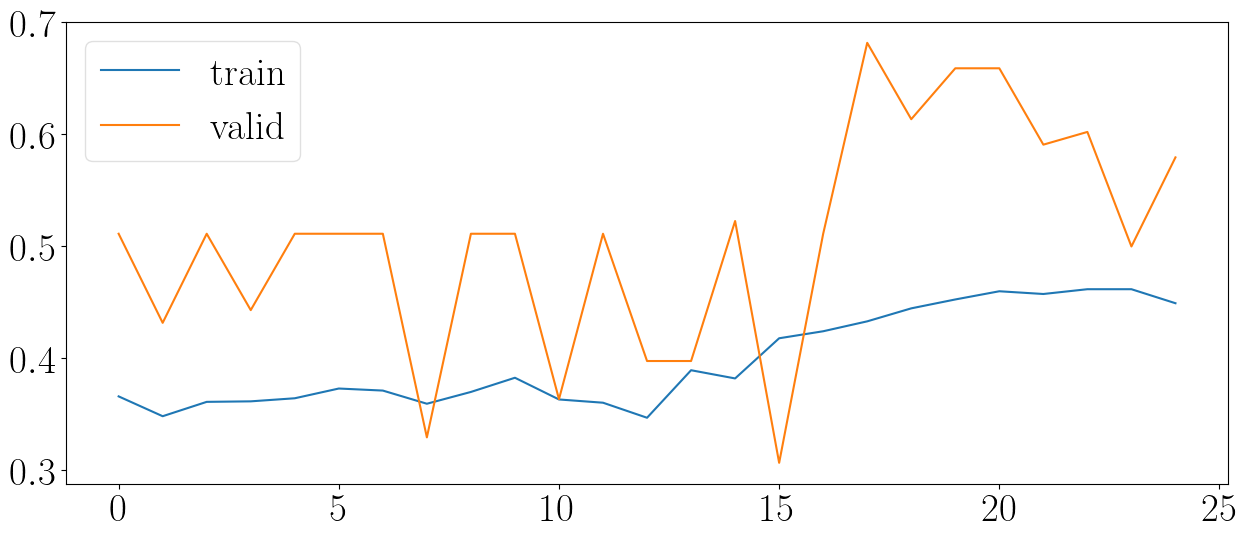

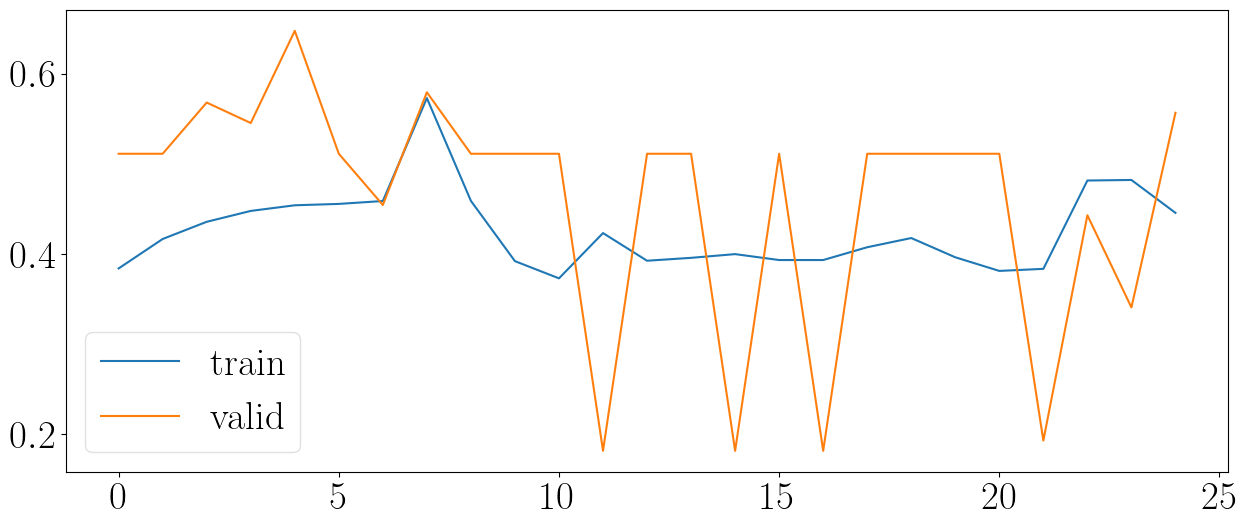

In [20]:
for i in range(len(train_accs)):
    plt.plot(train_accs[i], label='train')
    plt.plot(val_accs[i], label='valid')
    #plt.title(str(channels[i]))
    plt.legend()
    plt.show()

### 4. Threshold $\tau$

In [ ]:
tau_values = np.arange(0.1, 1.0, 0.2)

val_mse_tau = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for tau in tau_values:
    autoencoder = network.cae_3(
                            tau = tau, 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], 
                            padding = params_cae['padding']
                            ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_tau.append(np.mean(val_loss))

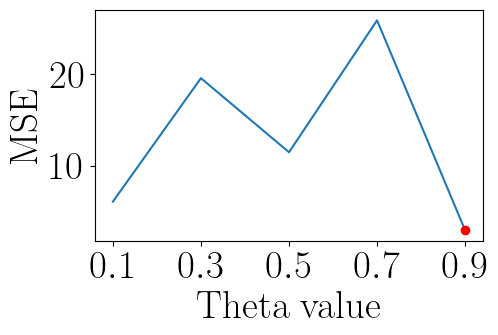

In [11]:
ind_min_tau = np.argmin(val_mse_tau)
plt.figure(figsize=(5,3))
plt.plot(tau_values, val_mse_tau)
plt.plot(tau_values[ind_min_tau], val_mse_tau[ind_min_tau], marker='o', color='red')
plt.xticks(tau_values)
plt.xlabel('Tau value')
plt.ylabel('MSE')
plt.show()

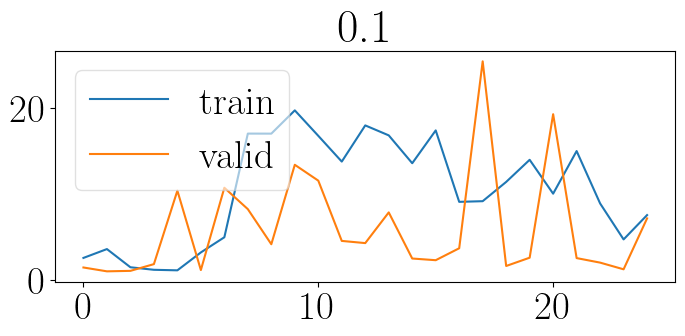

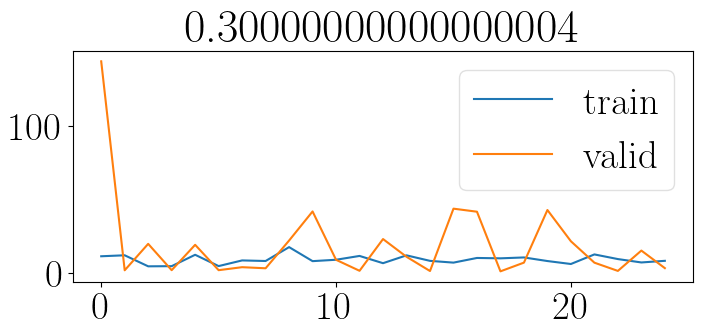

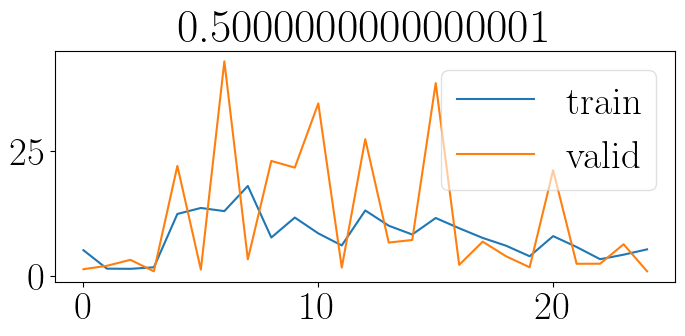

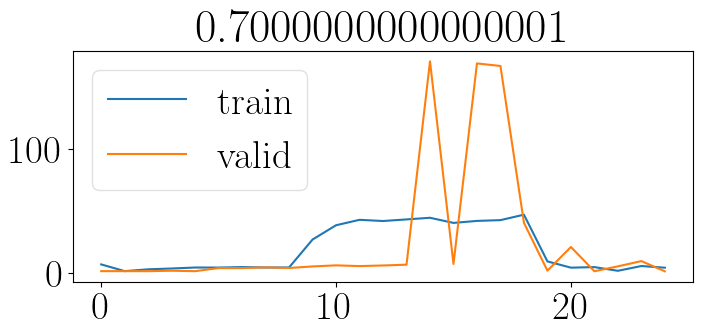

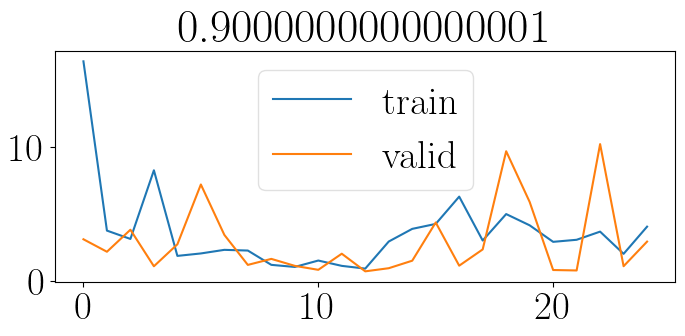

In [17]:
for i in range(len(train_losses)):
    plt.figure(figsize=(8,3))
    plt.plot(train_losses[i], label='train')
    plt.plot(val_losses[i], label='valid')
    plt.title(str(theta_values[i]))
    plt.legend()
    plt.show()

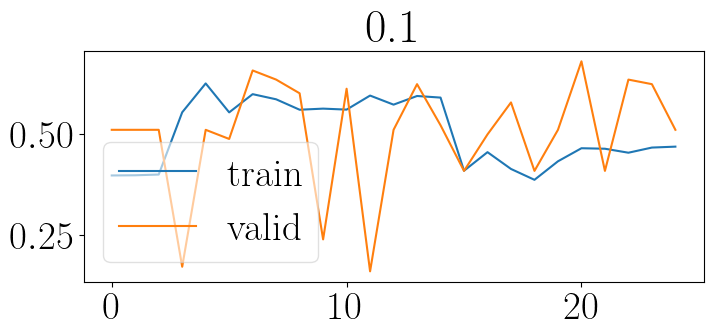

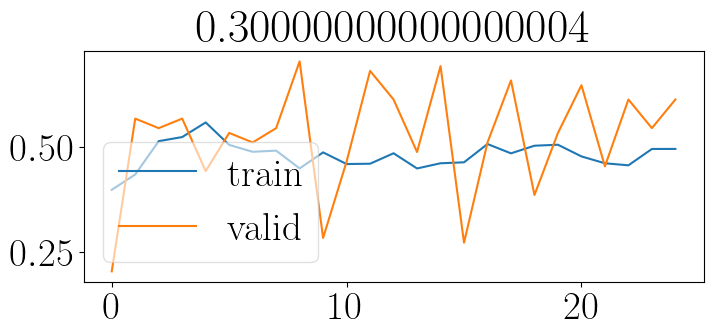

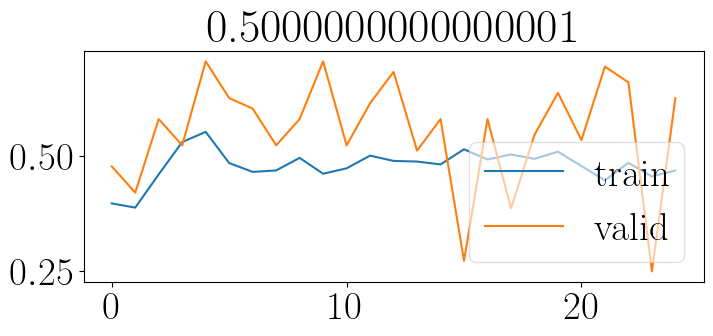

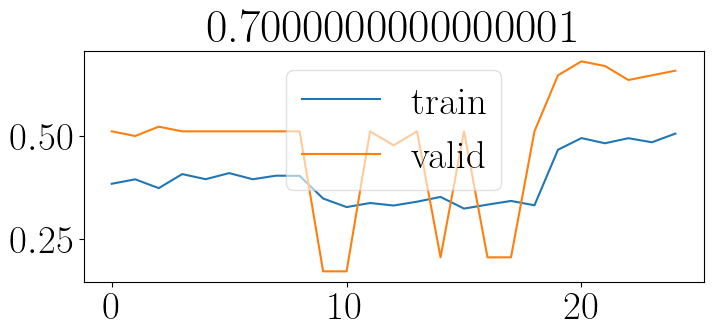

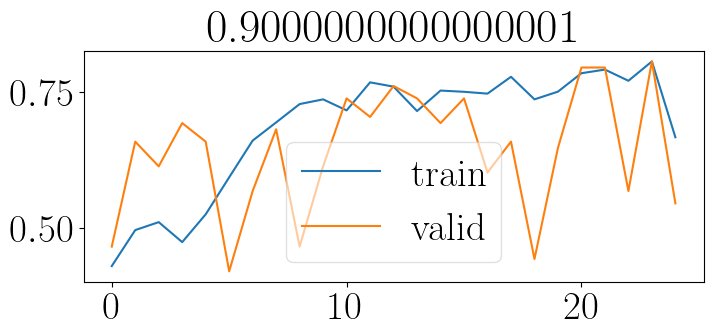

In [18]:
for i in range(len(train_accs)):
    plt.figure(figsize=(8,3))
    plt.plot(train_accs[i], label='train')
    plt.plot(val_accs[i], label='valid')
    plt.title(str(tau_values[i]))
    plt.legend()
    plt.show()

### 5. $\alpha$ e $\beta$

In [ ]:
alpha_values = np.array([0.99, 0.9, 0.85, 0.5])
beta_values = 1-alpha_values

val_mse_ab = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for alpha, beta in zip(alpha_values, beta_values):
    autoencoder = network.cae_3(
                            tau = params_cae['tau'], 
                            channels = params_cae['feature_maps'], 
                            kernel_size = params_cae['kernel'], 
                            stride = params_cae['stride'], 
                            padding = params_cae['padding']
                            ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = alpha, 
                                                        beta = beta, 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_ab.append(np.mean(val_loss))

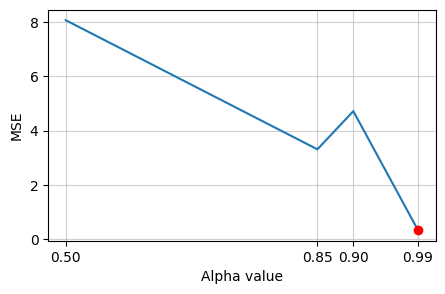

In [111]:
ind_min_ab = np.argmin(val_mse_ab)
plt.figure(figsize=(5,3))
plt.plot(alpha_values, val_mse_ab)
plt.plot(alpha_values[ind_min_ab], val_mse_ab[ind_min_ab], marker='o', color='red')
plt.xticks(alpha_values)
plt.xlabel('Alpha value')
plt.ylabel('MSE')
plt.grid(alpha=.6)
plt.show()

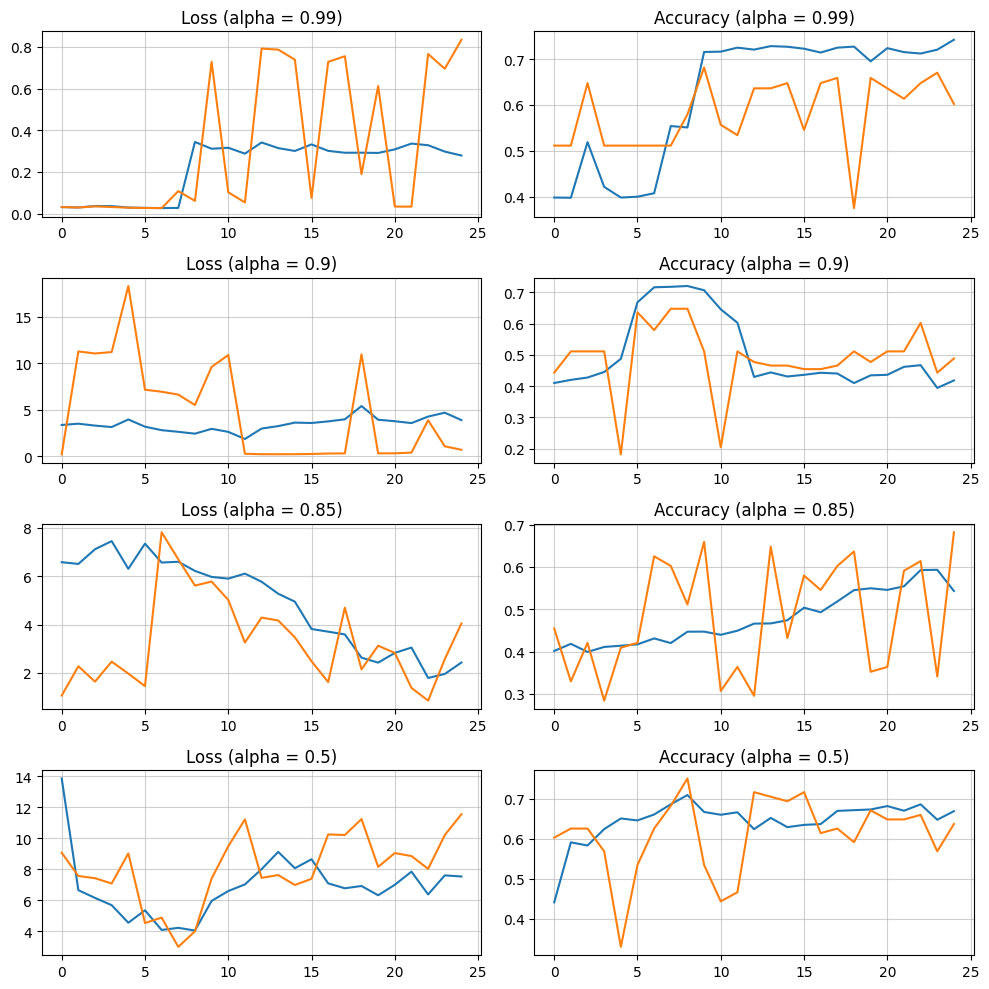

In [110]:
fig, axes = plt.subplots(len(alpha_values),2, figsize=(10,10)) 

for i, ax in enumerate(axes):
    ax[0].plot(train_losses[i], label='train')
    ax[0].plot(val_losses[i], label='valid')
    ax[0].set_title(f"Loss (alpha = {str(alpha_values[i])})")
    ax[0].grid(alpha=.6)
    ax[1].plot(train_accs[i], label='train')
    ax[1].plot(val_accs[i], label='valid')
    ax[1].set_title(f"Accuracy (alpha = {str(alpha_values[i])})")
    ax[1].grid(alpha=.6)

plt.tight_layout()
plt.show()

### 6. Number of SNN layers

In [ ]:
val_mse_snn_layers = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

### 2 hidden layers
snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
train_losses.append(train_loss)
val_losses.append(val_loss)
train_accs.append(train_acc)
val_accs.append(val_acc)
cae_losses.append(cae_loss)
snn_losses.append(snn_loss)
val_mse_snn_layers.append(np.mean(val_loss))

### 3 hidden layers
snn =  network.snn_2(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_eval.train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
train_losses.append(train_loss)
val_losses.append(val_loss)
train_accs.append(train_acc)
val_accs.append(val_acc)
cae_losses.append(cae_loss)
snn_losses.append(snn_loss)
val_mse_snn_layers.append(np.mean(val_loss))

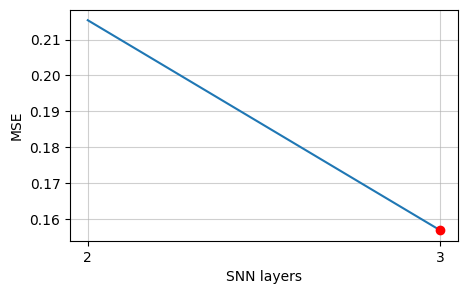

In [12]:
snn_layers = [2,3]
ind_min_snn_l = np.argmin(val_mse_snn_layers)
plt.figure(figsize=(5,3))
plt.plot(snn_layers, val_mse_snn_layers)
plt.plot(snn_layers[ind_min_snn_l], val_mse_snn_layers[ind_min_snn_l], marker='o', color='red')
plt.xticks([2,3])
plt.xlabel('SNN layers')
plt.ylabel('MSE')
plt.grid(alpha=.6)
plt.show()

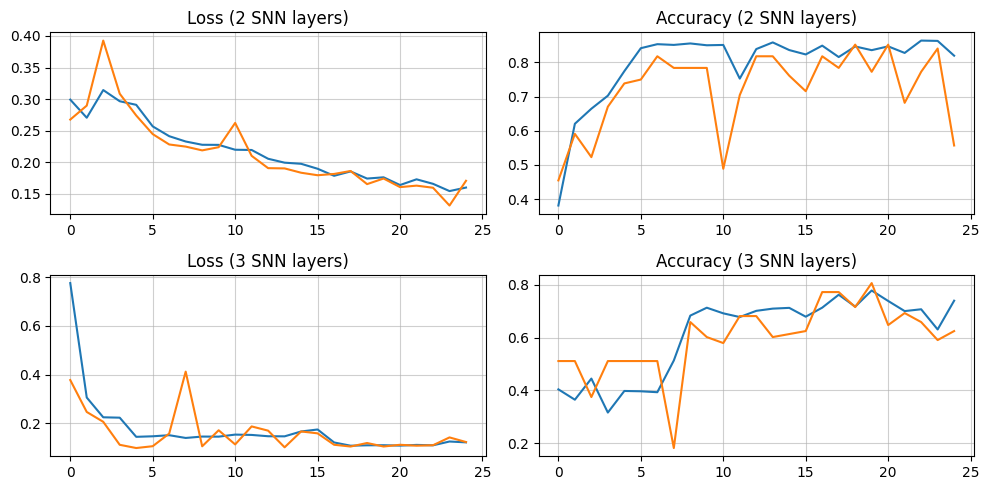

In [19]:
fig, axes = plt.subplots(2,2, figsize=(10,5)) 

for i, ax in enumerate(axes):
    ax[0].plot(train_losses[i], label='train')
    ax[0].plot(val_losses[i], label='valid')
    ax[0].set_title(f"Loss ({snn_layers[i]} SNN layers)")
    ax[0].grid(alpha=.6)
    ax[1].plot(train_accs[i], label='train')
    ax[1].plot(val_accs[i], label='valid')
    ax[1].set_title(f"Accuracy ({snn_layers[i]} SNN layers)")
    ax[1].grid(alpha=.6)

plt.tight_layout()
plt.show()

### 7. SNN hidden neurons

In [ ]:
hidden_neurons = [[128, 64], [64, 32], [32, 16], [16, 1]]

val_mse_lif = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

for neurons in hidden_neurons:

    snn =  network.snn_1(
                        input_dim = 2*10*64, 
                        hidden = neurons, 
                        n_classes = params_snn['num_classes'], 
                        surr_grad = params_snn['surrogate_grad'],
                        learn_thr = params_snn['learn_thr'], 
                        learn_beta = params_snn['learn_beta']
                        ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_lif.append(np.mean(val_loss))

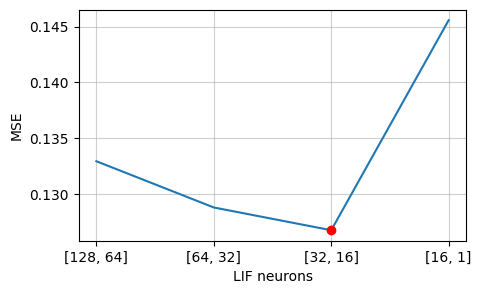

In [7]:
ind_min_lif = np.argmin(val_mse_lif)
plt.figure(figsize=(5,3))
plt.plot(val_mse_lif)
plt.plot(ind_min_lif, val_mse_lif[ind_min_lif], marker='o', color='red')
plt.xticks([0, 1, 2, 3], hidden_neurons)
plt.xlabel('LIF neurons')
plt.ylabel('MSE')
plt.grid(alpha=.6)
plt.show()

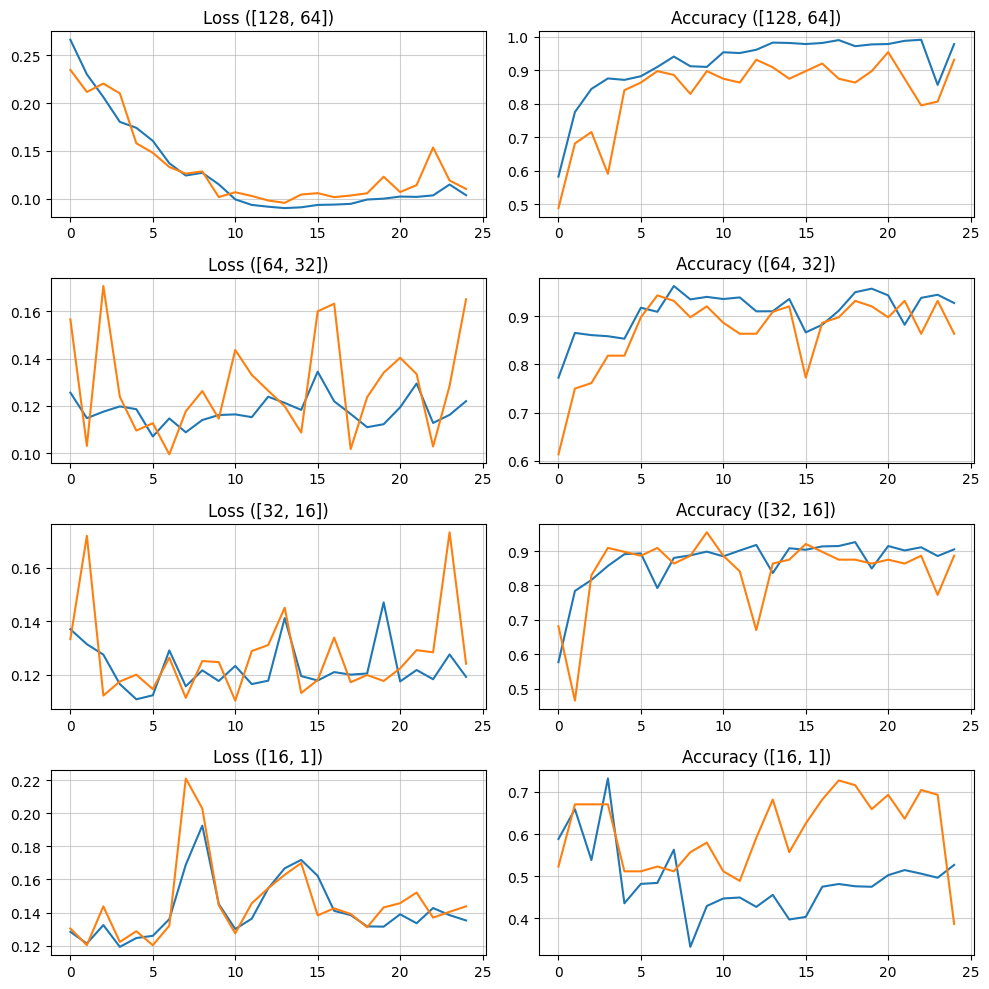

In [10]:
fig, axes = plt.subplots(len(hidden_neurons),2, figsize=(10,10)) 

for i, ax in enumerate(axes):
    ax[0].plot(train_losses[i], label='train')
    ax[0].plot(val_losses[i], label='valid')
    ax[0].set_title(f"Loss ({hidden_neurons[i]})")
    ax[0].grid(alpha=.6)
    ax[1].plot(train_accs[i], label='train')
    ax[1].plot(val_accs[i], label='valid')
    ax[1].set_title(f"Accuracy ({hidden_neurons[i]})")
    ax[1].grid(alpha=.6)

plt.tight_layout()
plt.show()

In [ ]:
hidden_neurons = [[128, 128], [64, 128], [128, 64]]

val_mse_lif = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

for neurons in hidden_neurons:

    snn =  network.snn_1(
                        input_dim = 2*10*64, 
                        hidden = neurons, 
                        n_classes = params_snn['num_classes'], 
                        surr_grad = params_snn['surrogate_grad'],
                        learn_thr = params_snn['learn_thr'], 
                        learn_beta = params_snn['learn_beta']
                        ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_eval.train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_lif.append(np.mean(val_loss))

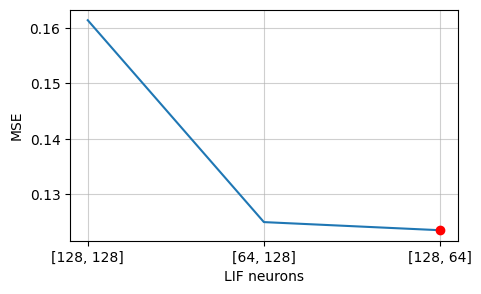

In [13]:
ind_min_lif = np.argmin(val_mse_lif)
plt.figure(figsize=(5,3))
plt.plot(val_mse_lif)
plt.plot(ind_min_lif, val_mse_lif[ind_min_lif], marker='o', color='red')
plt.xticks([0, 1, 2], hidden_neurons)
plt.xlabel('LIF neurons')
plt.ylabel('MSE')
plt.grid(alpha=.6)
plt.show()

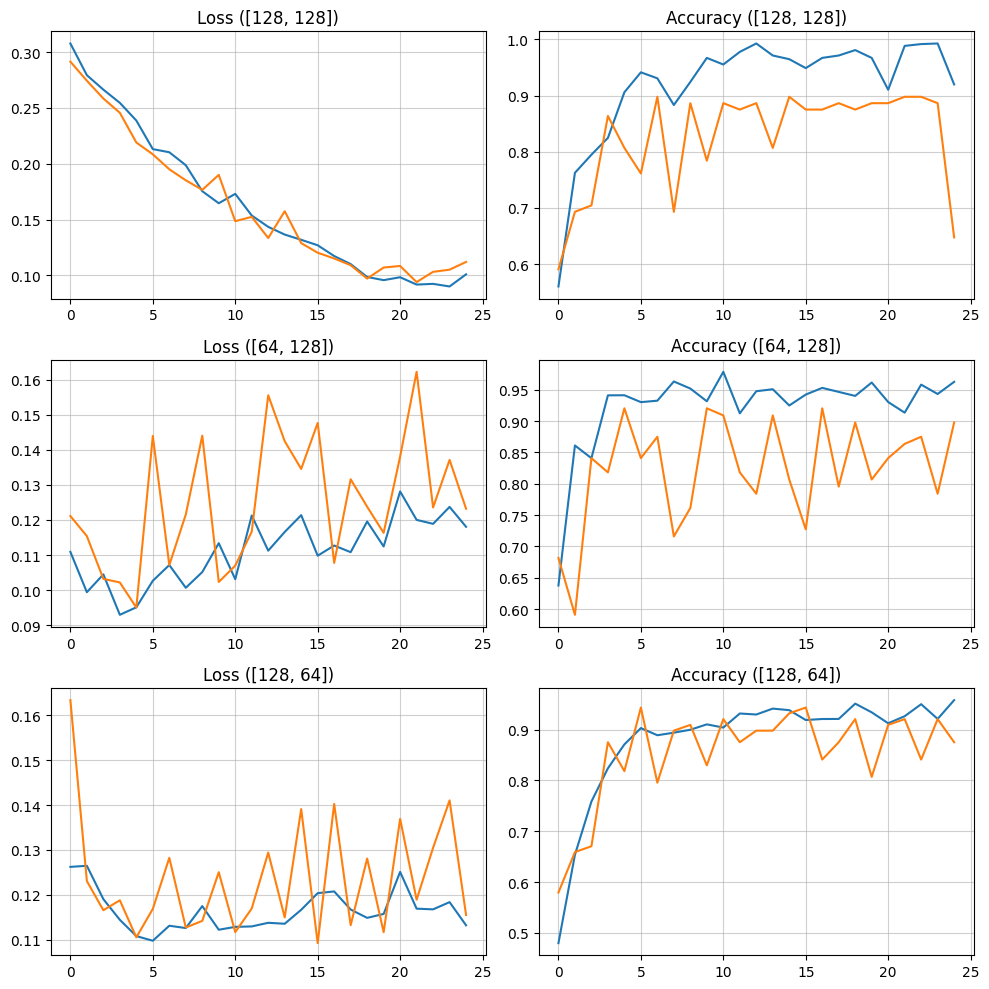

In [14]:
fig, axes = plt.subplots(len(hidden_neurons),2, figsize=(10,10)) 

for i, ax in enumerate(axes):
    ax[0].plot(train_losses[i], label='train')
    ax[0].plot(val_losses[i], label='valid')
    ax[0].set_title(f"Loss ({hidden_neurons[i]})")
    ax[0].grid(alpha=.6)
    ax[1].plot(train_accs[i], label='train')
    ax[1].plot(val_accs[i], label='valid')
    ax[1].set_title(f"Accuracy ({hidden_neurons[i]})")
    ax[1].grid(alpha=.6)

plt.tight_layout()
plt.show()

### 8. Surrogate gradient

In [ ]:
surr_gradients = [surrogate.atan(), surrogate.fast_sigmoid(), 
                  surrogate.straight_through_estimator()]
val_mse_surr = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

for surr_gd in surr_gradients:

    snn =  network.snn_1(
                        input_dim = 2*10*64, 
                        hidden = params_snn['hidden_layers'], 
                        n_classes = params_snn['num_classes'], 
                        surr_grad = surr_gd,
                        learn_thr = params_snn['learn_thr'], 
                        learn_beta = params_snn['learn_beta']
                        ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_surr.append(np.mean(val_loss))

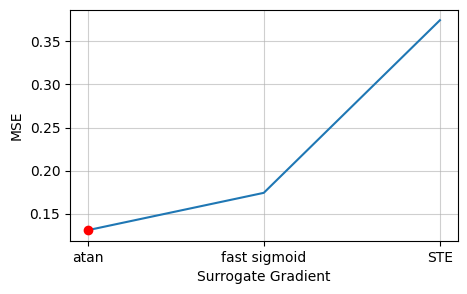

In [25]:
ind_min_surr = np.argmin(val_mse_surr)
plt.figure(figsize=(5,3))
plt.plot(val_mse_surr)
plt.plot(ind_min_surr, val_mse_surr[ind_min_surr], marker='o', color='red')
plt.xticks([0, 1, 2], ["atan", "fast sigmoid", "STE"])
plt.xlabel('Surrogate Gradient')
plt.ylabel('MSE')
plt.grid(alpha=.6)
plt.show()

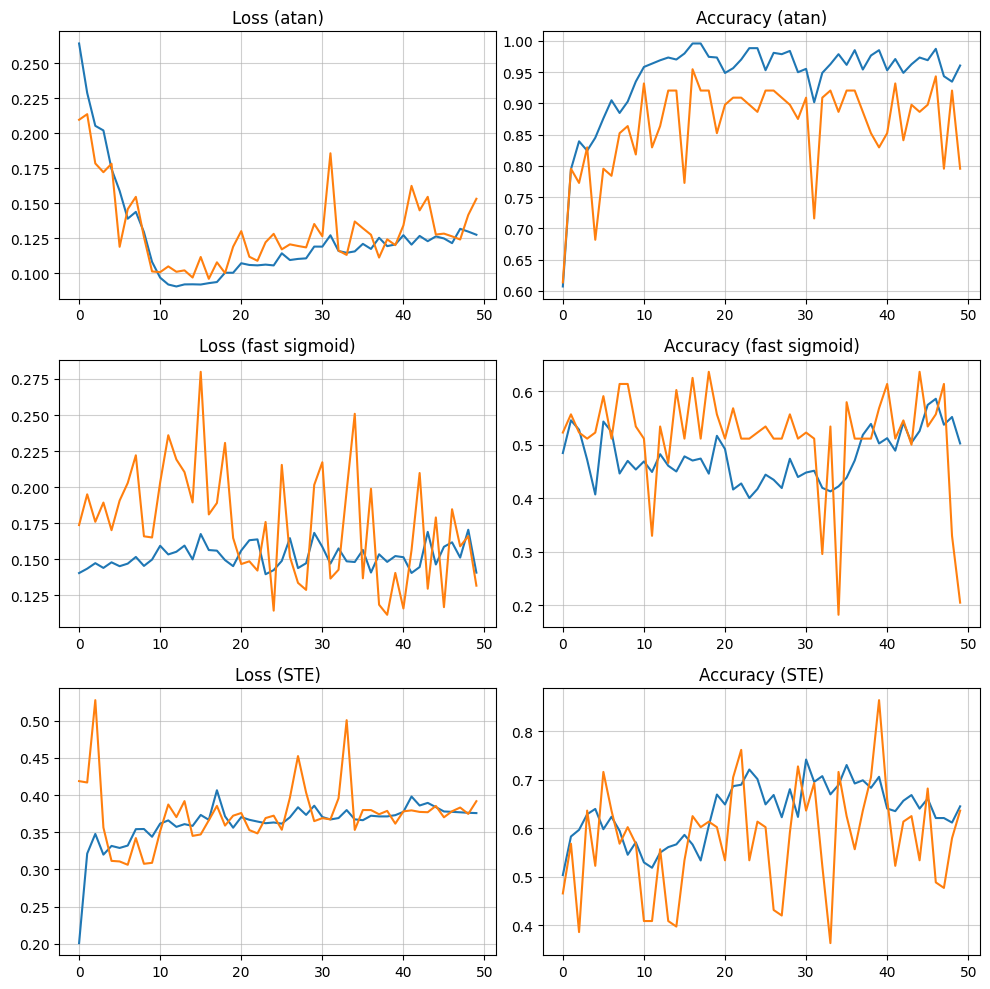

In [27]:
surr_gradients = ["atan", "fast sigmoid", "STE"]
fig, axes = plt.subplots(len(surr_gradients),2, figsize=(10,10)) 

for i, ax in enumerate(axes):
    ax[0].plot(train_losses[i], label='train')
    ax[0].plot(val_losses[i], label='valid')
    ax[0].set_title(f"Loss ({surr_gradients[i]})")
    ax[0].grid(alpha=.6)
    ax[1].plot(train_accs[i], label='train')
    ax[1].plot(val_accs[i], label='valid')
    ax[1].set_title(f"Accuracy ({surr_gradients[i]})")
    ax[1].grid(alpha=.6)

plt.tight_layout()
plt.show()

### 9. Optimization algorithm

In [31]:
val_mse_opt = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
train_losses.append(train_loss)
val_losses.append(val_loss)
train_accs.append(train_acc)
val_accs.append(val_acc)
cae_losses.append(cae_loss)
snn_losses.append(snn_loss)
val_mse_opt.append(np.mean(val_loss))


optimizer = torch.optim.SGD(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
train_losses.append(train_loss)
val_losses.append(val_loss)
train_accs.append(train_acc)
val_accs.append(val_acc)
cae_losses.append(cae_loss)
snn_losses.append(snn_loss)
val_mse_opt.append(np.mean(val_loss))

In [ ]:
ind_min_opt = np.argmin(val_mse_opt)
plt.figure(figsize=(5,3))
plt.plot(val_mse_opt)
plt.plot(ind_min_opt, val_mse_opt[ind_min_opt], marker='o', color='red')
plt.xticks([0, 1, 2], ["Adam", "SGD"])
plt.xlabel('Optimization algorithm')
plt.ylabel('MSE')
plt.grid(alpha=.6)
plt.show()

In [ ]:
opt_algo = ["Adam", "SGD"]
fig, axes = plt.subplots(len(opt_algo),2, figsize=(10,10)) 

for i, ax in enumerate(axes):
    ax[0].plot(train_losses[i], label='train')
    ax[0].plot(val_losses[i], label='valid')
    ax[0].set_title(f"Loss ({opt_algo[i]})")
    ax[0].grid(alpha=.6)
    ax[1].plot(train_accs[i], label='train')
    ax[1].plot(val_accs[i], label='valid')
    ax[1].set_title(f"Accuracy ({opt_algo[i]})")
    ax[1].grid(alpha=.6)

plt.tight_layout()
plt.show()

### 10. Learning rate

In [ ]:
learning_rates = [1e-4, 1e-3, 1e-2]

val_mse_lr = []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []

autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

for eta in learning_rates:

    snn =  network.snn_1(
                        input_dim = 2*10*64, 
                        hidden = params_snn['hidden_layers'], 
                        n_classes = params_snn['num_classes'], 
                        surr_grad = params_snn['surrogate_grad'],
                        learn_thr = params_snn['learn_thr'], 
                        learn_beta = params_snn['learn_beta']
                        ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = eta)

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = params_train['lambda_reg'], 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_lr.append(np.mean(val_loss))

In [ ]:
fig, axes = plt.subplots(len(learning_rates),2, figsize=(10,10)) 

for i, ax in enumerate(axes):
    ax[0].plot(train_losses[i], label='train')
    ax[0].plot(val_losses[i], label='valid')
    ax[0].set_title(f"Loss ({learning_rates[i]})")
    ax[0].grid(alpha=.6)
    ax[1].plot(train_accs[i], label='train')
    ax[1].plot(val_accs[i], label='valid')
    ax[1].set_title(f"Accuracy ({learning_rates[i]})")
    ax[1].grid(alpha=.6)

plt.tight_layout()
plt.show()

### Grid Search

In [ ]:
def objective(config):  
    assert torch.cuda.is_available()

    autoencoder = network.cae_3(
                        tau = config['tau'], 
                        channels = config['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)
    
    snn =  network.snn_1(
                        input_dim = 2*10*64, 
                        hidden = config['hidden_layers'], 
                        n_classes = params_snn['num_classes'], 
                        surr_grad = config['surrogate_grad'],
                        learn_thr = params_snn['learn_thr'], 
                        learn_beta = params_snn['learn_beta']
                        ).to(device)
    
    model = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    while True:
        train_loss, val_loss, train_acc, val_acc, _, _ = train_fn(model = model, 
                    train = train_loader, valid = val_loader, 
                    loss_fn_cae = params_cae['loss_fn'], 
                    out_dec = params_snn['output_dec'],
                    optimizer = optimizer,
                    acc_steps = params_train['acc_steps'],
                    alpha = config['alpha'], 
                    beta = 1-config['alpha'], 
                    Lambda = params_train['lambda_reg'], 
                    epochs = params_train['epochs'], 
                    patience = params_train['patience'], 
                    path = None,
                    verbose = False)  
        acc = np.mean(val_acc)
        train.report({"mean_accuracy": acc})  

search_space = {"lr": tune.grid_search([1e-4, 1e-3]), 
                "alpha": tune.grid_search([0.99, 0.85]),
                "tau": tune.grid_search([0.1, 0.5, 0.9]),
                "feature_maps": tune.grid_search([[64, 128], [128, 128]]),
                "hidden_layers": tune.grid_search([[128, 64], [128, 128]]),
                "surrogate_grad": tune.grid_search([surrogate.atan(), surrogate.fast_sigmoid()])
                }

algo = BasicVariantGenerator() 

tuner = tune.Tuner( 
    tune.with_resources(
                        tune.with_parameters(objective),
                        resources={"cpu": 1, "gpu": 1}
                        ),
    tune_config = tune.TuneConfig(
                                metric = "mean_accuracy",
                                mode = "max",
                                search_alg = algo,
                                ),
    run_config = train.RunConfig(
                                name = "grid_search",
                                stop = {"training_iteration": 2, "mean_accuracy": 0.8},
                                ),
    param_space = search_space,
)
results = tuner.fit()
print("Best config is:", results.get_best_result().config)

In [15]:
results_df= pd.read_csv('GridSearch_results.csv', header=0).drop(['Unnamed: 0'], axis=1)
results_df.rename(columns={'config/lr': 'lr', 'config/alpha': 'alpha',
                           'config/tau': 'tau', 
                           'config/feature_maps': 'feature_maps',
                           'config/hidden_layers': 'hidden_layers', 
                           'config/surrogate_grad': 'surrogate_grad'},
                           inplace=True)
results_df.sort_values(by='mean_accuracy', axis=0, ascending=False).head()

mean_accuracy      lr  alpha  tau feature_maps hidden_layers  \
18       0.916866  0.0001   0.85  0.1   [128, 128]     [128, 64]   
40       0.915813  0.0010   0.85  0.5    [64, 128]     [128, 64]   
64       0.908448  0.0001   0.85  0.9    [64, 128]     [128, 64]   
86       0.907895  0.0001   0.85  0.9   [128, 128]    [128, 128]   
69       0.905924  0.0001   0.99  0.9   [128, 128]    [128, 128]   

                                       surrogate_grad  
18  <function fast_sigmoid.<locals>.inner at 0x7b4...  
40   <function atan.<locals>.inner at 0x7b4518028040>  
64   <function atan.<locals>.inner at 0x7b4518028040>  
86  <function fast_sigmoid.<locals>.inner at 0x7b4...  
69   <function atan.<locals>.inner at 0x7b4518028040>

In [13]:
results_df.to_csv('GridSearch_results.csv')

## Sparsity regularization

In [ ]:
lambda_reg = np.arange(0.0, 1.1, 0.1)

val_mse_reg, sparsity = [], []
train_losses, val_losses = [], []
train_accs, val_accs = [], []
cae_losses, snn_losses = [], []


snn =  network.snn_1(
                    input_dim = 2*10*64, hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for lambda_ in lambda_reg:
    autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)
    
    net = LSE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                        model = net, 
                                                        train = train_loader, 
                                                        valid = val_loader,
                                                        loss_fn_cae = params_cae['loss_fn'], 
                                                        out_dec = params_snn['output_dec'],
                                                        optimizer = optimizer, 
                                                        acc_steps = params_train['acc_steps'],
                                                         alpha = params_train['alpha'], 
                                                        beta = params_train['beta'], 
                                                        Lambda = lambda_, 
                                                        epochs = params_train['epochs'], 
                                                        patience = params_train['patience'], 
                                                        path = None)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    cae_losses.append(cae_loss)
    snn_losses.append(snn_loss)
    val_mse_reg.append(np.mean(val_loss))

    net.eval()
    with torch.no_grad():
        spars = 0

        for X, _, _ in val_loader:
            X = X.to(device)
            spike = net(X.float())[0]
            spars += 1 - torch.mean(abs(spike))
        sparsity.append(spars.cpu().numpy()/len(val_loader))

In [16]:
metrics = pd.DataFrame({'Lambda': lambda_reg, 'Sparsity': sparsity, 'Error': val_mse_reg})

display(metrics)

Lambda  Sparsity     Error
0      0.0  0.134537  0.138094
1      0.1  0.606486  0.162568
2      0.2  0.680886  0.202307
3      0.3  0.675173  0.191328
4      0.4  0.746130  0.238929
5      0.5  0.664663  0.269385
6      0.6  0.834073  0.288670
7      0.7  0.787778  0.276995
8      0.8  0.751619  0.286020
9      0.9  0.678741  0.335241
10     1.0  0.772314  0.336027

In [ ]:
metrics.to_csv('Sparsity_vs_error.csv')

In [59]:
metrics = pd.read_csv('Sparsity_vs_error.csv')

In [66]:
lambda_reg = metrics.Lambda.values
sparsity = metrics.Sparsity.values
val_mse_reg = metrics.Error.values

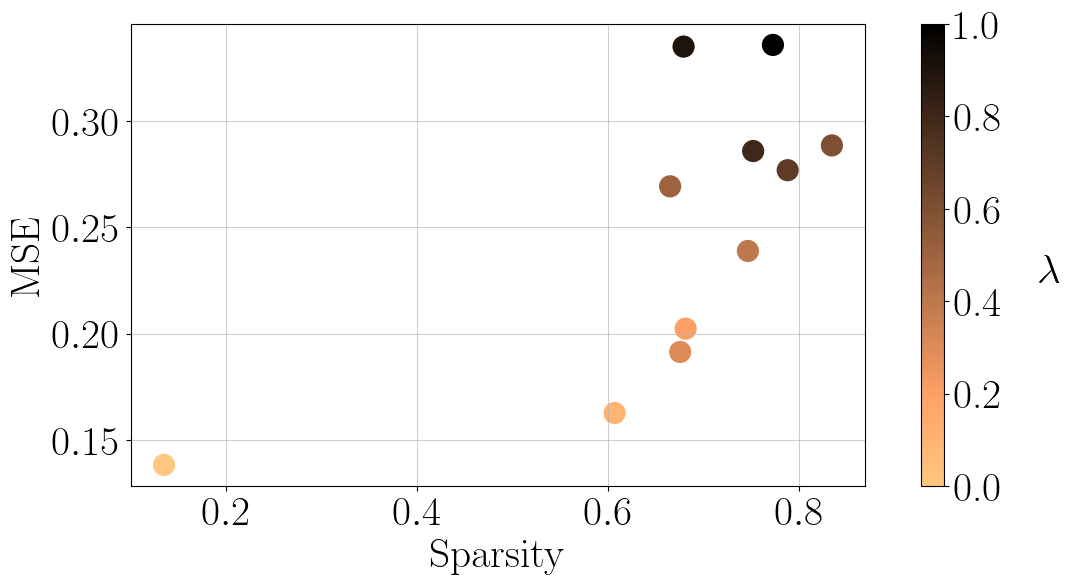

In [78]:
plt.figure()
plt.scatter(sparsity, val_mse_reg, cmap=plt.colormaps.get_cmap('copper_r'),
            c=lambda_reg, linewidths=10)
plt.xlabel("Sparsity")
plt.ylabel("MSE")
#plt.xticks(np.arange(0.2,0.9, 0.2))
#plt.yticks([0.08, 0.09, 0.1])
plt.grid()
colorbar = plt.colorbar(pad=0.06)#, location='top', orientation='horizontal')
colorbar.set_label(r'$\lambda$', labelpad=35, rotation=0)
colorbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
#colorbar.set_ticks(lambda_reg)
colorbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
#colorbar.set_ticklabels(np.round(lambda_reg,1))
plt.savefig("Plots/sparsity_vs_mse.pdf", bbox_inches='tight')
plt.show()

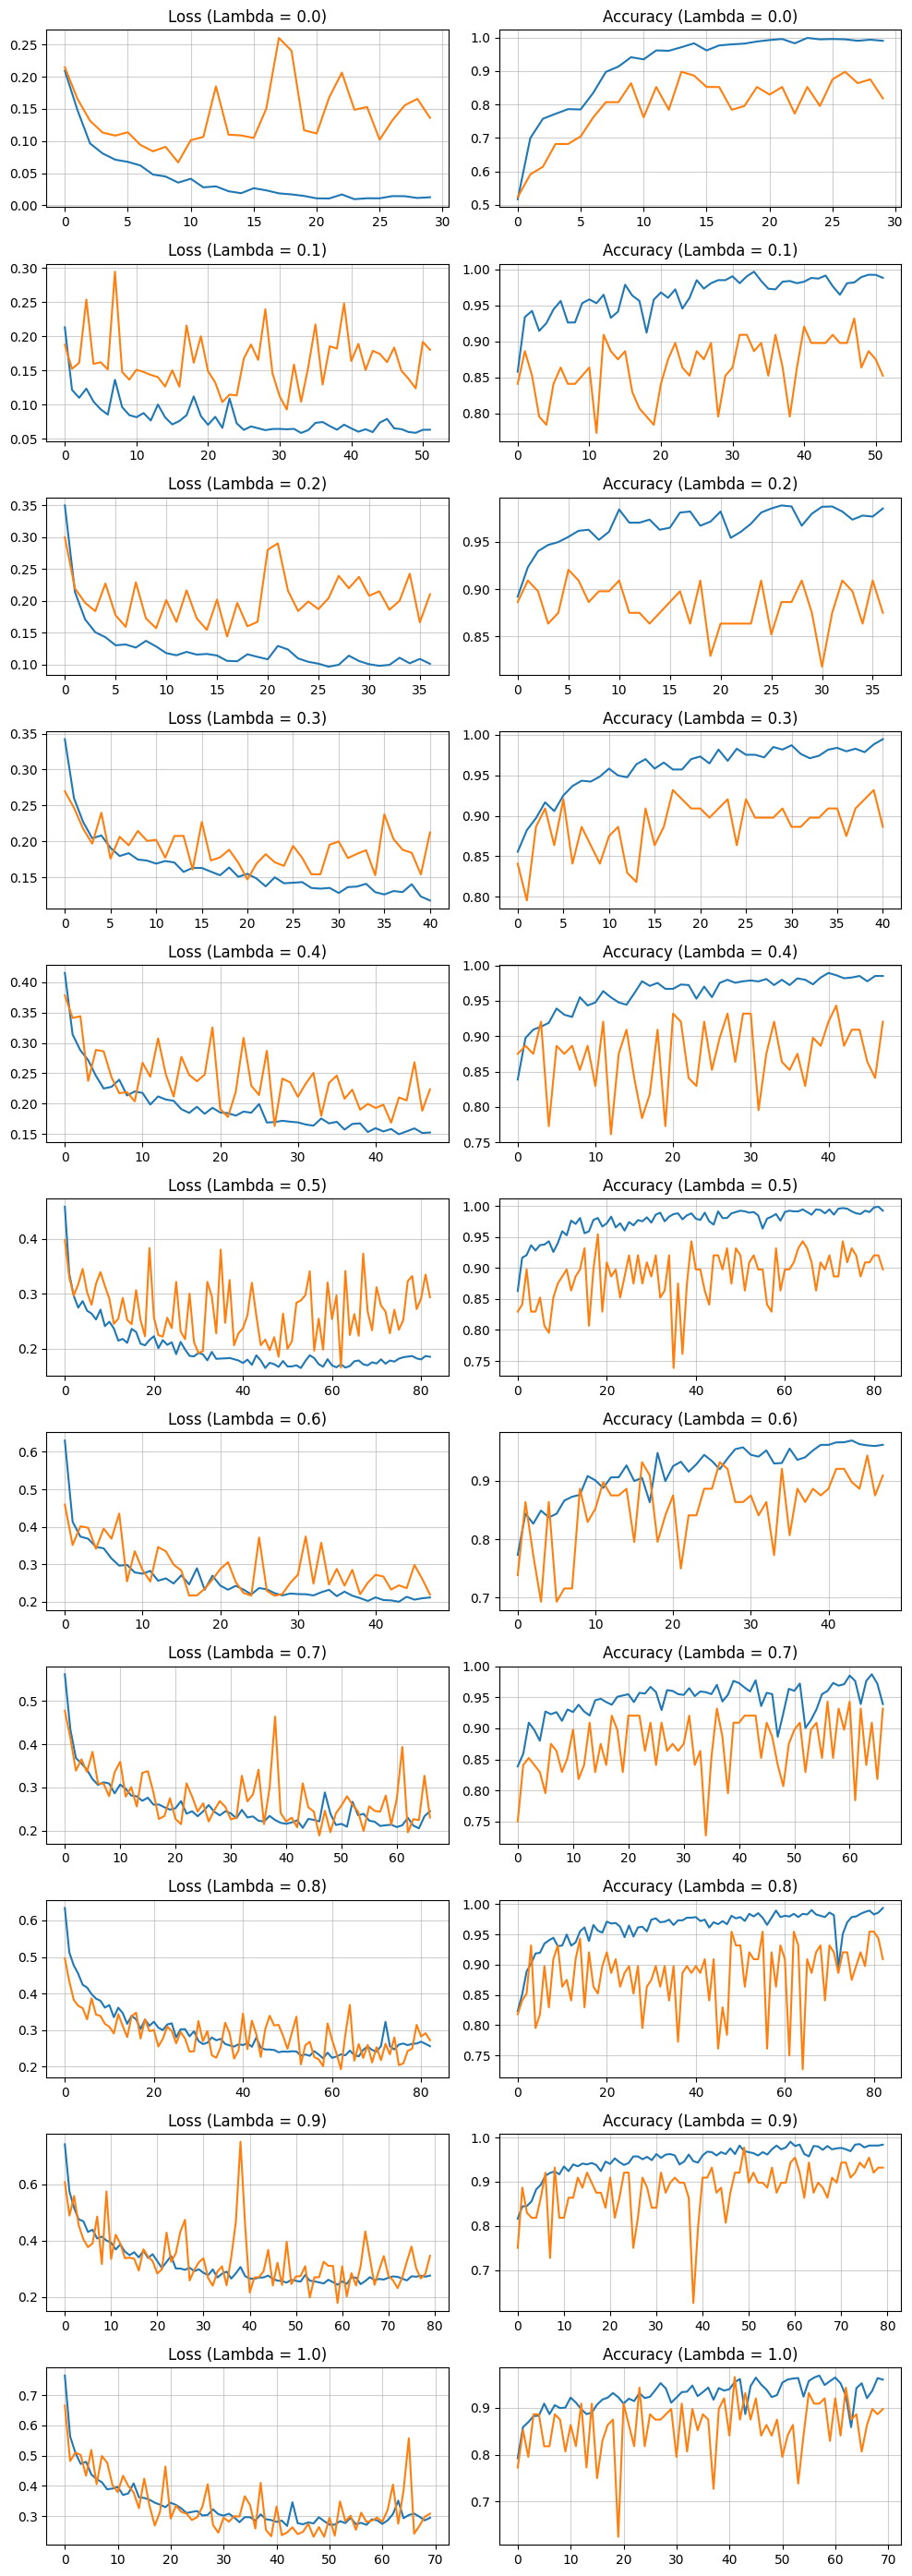

In [23]:
fig, axes = plt.subplots(len(lambda_reg),2, figsize=(10,28)) 

for i, ax in enumerate(axes):
    ax[0].plot(train_losses[i], label='train')
    ax[0].plot(val_losses[i], label='valid')
    ax[0].set_title(f"Loss (Lambda = {str(round(lambda_reg[i],1))})")
    ax[0].grid(alpha=.6)
    ax[1].plot(train_accs[i], label='train')
    ax[1].plot(val_accs[i], label='valid')
    ax[1].set_title(f"Accuracy (Lambda = {str(round(lambda_reg[i],1))})")
    ax[1].grid(alpha=.6)

plt.tight_layout()
plt.show()

## Train with optimized hyperparams

In [4]:
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc, cae_loss, snn_loss = train_fn(
                                                    model = net, 
                                                    train = train_loader, 
                                                    valid = val_loader,
                                                    loss_fn_cae = params_cae['loss_fn'], 
                                                    out_dec = params_snn['output_dec'],
                                                    optimizer = optimizer, 
                                                    acc_steps = params_train['acc_steps'],
                                                    alpha = params_train['alpha'], 
                                                    beta = params_train['beta'], 
                                                    Lambda = params_train['lambda_reg'], 
                                                    epochs = params_train['epochs'], 
                                                    patience = params_train['patience'], 
                                                    path = './model_opt_2.pt')


Epoch 1 - loss: 0.4153 | acc: 0.4708 | val_loss: 0.4535 | val_acc: 0.4659
Epoch 2 - loss: 0.2961 | acc: 0.705 | val_loss: 0.2951 | val_acc: 0.6136
Epoch 3 - loss: 0.2493 | acc: 0.7627 | val_loss: 0.2461 | val_acc: 0.6705
Epoch 4 - loss: 0.2509 | acc: 0.7401 | val_loss: 0.2682 | val_acc: 0.5909
Epoch 5 - loss: 0.2349 | acc: 0.7883 | val_loss: 0.2257 | val_acc: 0.7841
Epoch 6 - loss: 0.2283 | acc: 0.7817 | val_loss: 0.2525 | val_acc: 0.6818
Epoch 7 - loss: 0.2126 | acc: 0.8129 | val_loss: 0.2482 | val_acc: 0.6818
Epoch 8 - loss: 0.2029 | acc: 0.8364 | val_loss: 0.2091 | val_acc: 0.7614
Epoch 9 - loss: 0.2069 | acc: 0.8223 | val_loss: 0.2115 | val_acc: 0.7614
Epoch 10 - loss: 0.2024 | acc: 0.8437 | val_loss: 0.3063 | val_acc: 0.6818
Epoch 11 - loss: 0.2049 | acc: 0.8567 | val_loss: 0.229 | val_acc: 0.7955
Epoch 12 - loss: 0.1817 | acc: 0.8768 | val_loss: 0.2241 | val_acc: 0.7841
Epoch 13 - loss: 0.1797 | acc: 0.8919 | val_loss: 0.2572 | val_acc: 0.7386
Epoch 14 - loss: 0.1723 | acc: 0.898

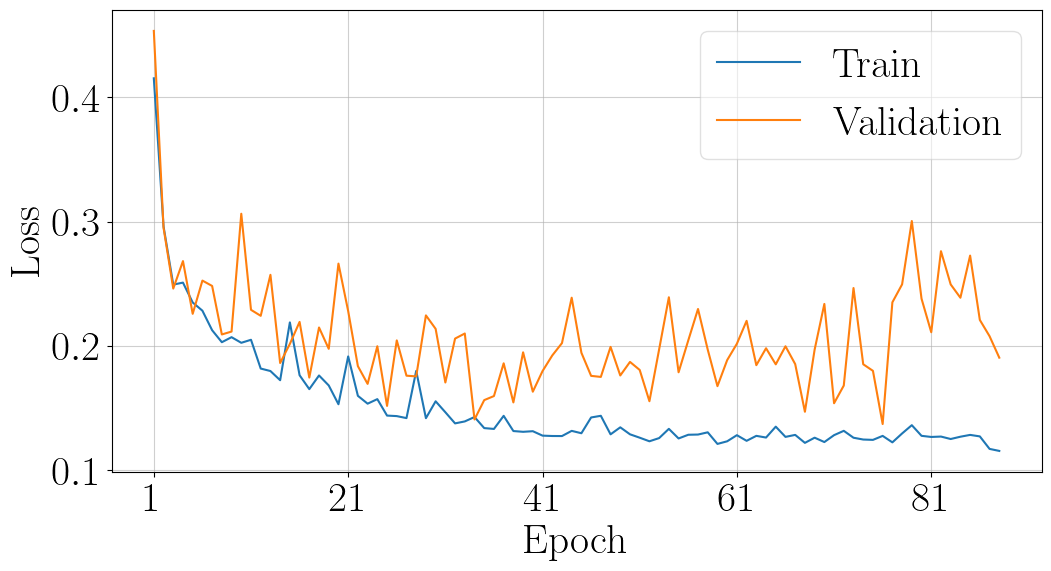

In [48]:
#plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/train_val_loss.png", bbox_inches='tight')
plt.show()

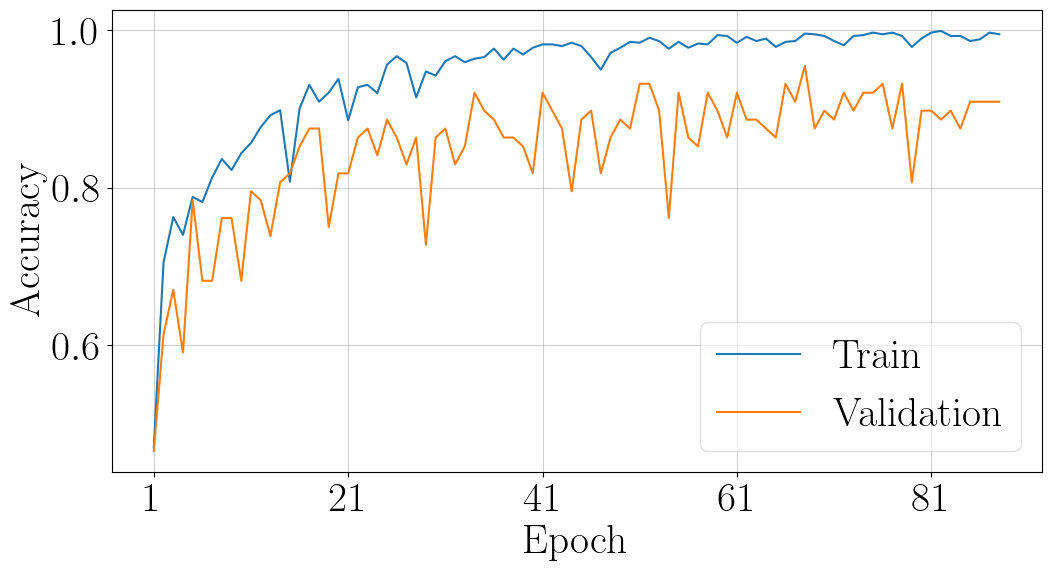

In [51]:
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/train_val_acc.png", bbox_inches='tight')
plt.show()

# Results on test set

In [10]:
path = "./models/model_opt_2.pt"
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE(
  (autoencoder): cae_3(
    (encoder): Sequential(
      (0): Conv3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Conv3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv3d(128, 2, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (4): BatchNorm3d(12

In [55]:
acc, prec, rec, f1, confusion_mx = evaluate(net, test_loader, 
                                            out_dec="rate", avg_type='macro',
                                            verbose=False)

AVERAGE TYPE: macro

Accuracy: 0.9551
Precision: 0.9452
Recall: 0.9196
F1 score: 0.9237


In [13]:
acc, prec, rec, f1, confusion_mx = evaluate(net, test_loader, 
                                            out_dec="rate", avg_type='macro',
                                            verbose=False)

IndexError: index 211 is out of bounds for dimension 2 with size 211

In [56]:
acc, prec, rec, f1, confusion_mx = evaluate(net, test_loader, 
                                            out_dec="rate", avg_type='weighted')

AVERAGE TYPE: weighted

Accuracy: 0.9196
Precision: 0.9613
Recall: 0.9551
F1 score: 0.9537

Classification Report:
               precision    recall  f1-score   support

     WALKING       1.00      0.98      0.99        46
     RUNNING       0.95      1.00      0.97        18
     SITTING       0.83      1.00      0.91        15
       HANDS       1.00      0.70      0.82        10

    accuracy                           0.96        89
   macro avg       0.95      0.92      0.92        89
weighted avg       0.96      0.96      0.95        89



### Plot the confusion matrix

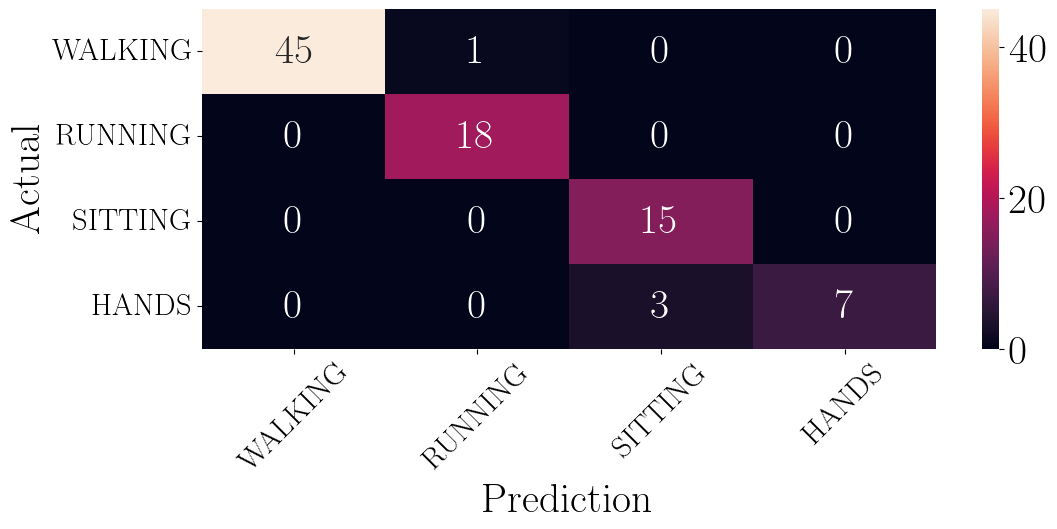

In [50]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/confusion_mx_macro.pdf", bbox_inches='tight')
plt.show()

## Encoding CAE vs. LIF

In [6]:
class LSE_1(nn.Module):
    def __init__(self, autoencoder, classifier):
        super(LSE_1, self).__init__()
        self.autoencoder = autoencoder
        self.classifier = classifier

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.classifier(encoded)  
        return encoded, decoded, clss

In [21]:
hidden_neurons_sae = [16, 32, 128]
train_loss_ls, val_loss_ls = [], []
train_acc_ls, val_acc_ls = [], []

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    timesteps = N_WIN,
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

for hidd in hidden_neurons_sae:

    autoencoder = sae.sae_lin2(
                            input_dim = 64, 
                            hidden_dim = hidd,
                            surr_grad = params_snn['surrogate_grad'],
                            learn_beta = params_snn['learn_beta'],
                            timesteps = N_WIN
                            ).to(device)
    
    net = LSE_1(autoencoder, classifier).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

    train_loss, val_loss, train_acc, val_acc = train_fn(
                                                    model = net, 
                                                    train = train_loader, 
                                                    valid = val_loader,
                                                    loss_fn_cae = params_cae['loss_fn'], 
                                                    out_dec = params_snn['output_dec'],
                                                    optimizer = optimizer, 
                                                    acc_steps = params_train['acc_steps'],
                                                    alpha = params_train['alpha'], 
                                                    beta = params_train['beta'], 
                                                    Lambda = params_train['lambda_reg'], 
                                                    epochs = params_train['epochs'], 
                                                    patience = params_train['patience'], 
                                                    path = None)

    train_loss_ls.append(train_loss)
    val_loss_ls.append(val_loss)
    train_acc_ls.append(train_acc)
    val_acc_ls.append(val_acc)

Epoch 1 - loss: 0.4281 | acc: 0.3817 | val_loss: 0.2742 | val_acc: 0.4886
Epoch 2 - loss: 0.2707 | acc: 0.3724 | val_loss: 0.2676 | val_acc: 0.5
Epoch 3 - loss: 0.2701 | acc: 0.3884 | val_loss: 0.2641 | val_acc: 0.5114
Epoch 4 - loss: 0.2701 | acc: 0.3919 | val_loss: 0.2703 | val_acc: 0.4659
Epoch 5 - loss: 0.2745 | acc: 0.3794 | val_loss: 0.2714 | val_acc: 0.4659
Epoch 6 - loss: 0.268 | acc: 0.3819 | val_loss: 0.2786 | val_acc: 0.3523
Epoch 7 - loss: 0.2641 | acc: 0.3767 | val_loss: 0.2593 | val_acc: 0.4432
Epoch 8 - loss: 0.252 | acc: 0.3858 | val_loss: 0.2538 | val_acc: 0.4318
Epoch 9 - loss: 0.2474 | acc: 0.4061 | val_loss: 0.2408 | val_acc: 0.5
Epoch 10 - loss: 0.2446 | acc: 0.4232 | val_loss: 0.2512 | val_acc: 0.4432
Epoch 11 - loss: 0.2386 | acc: 0.4524 | val_loss: 0.2375 | val_acc: 0.4091
Epoch 12 - loss: 0.2389 | acc: 0.4684 | val_loss: 0.2373 | val_acc: 0.4659
Epoch 13 - loss: 0.2225 | acc: 0.4973 | val_loss: 0.2059 | val_acc: 0.5568
Epoch 14 - loss: 0.2093 | acc: 0.5668 | va

[]

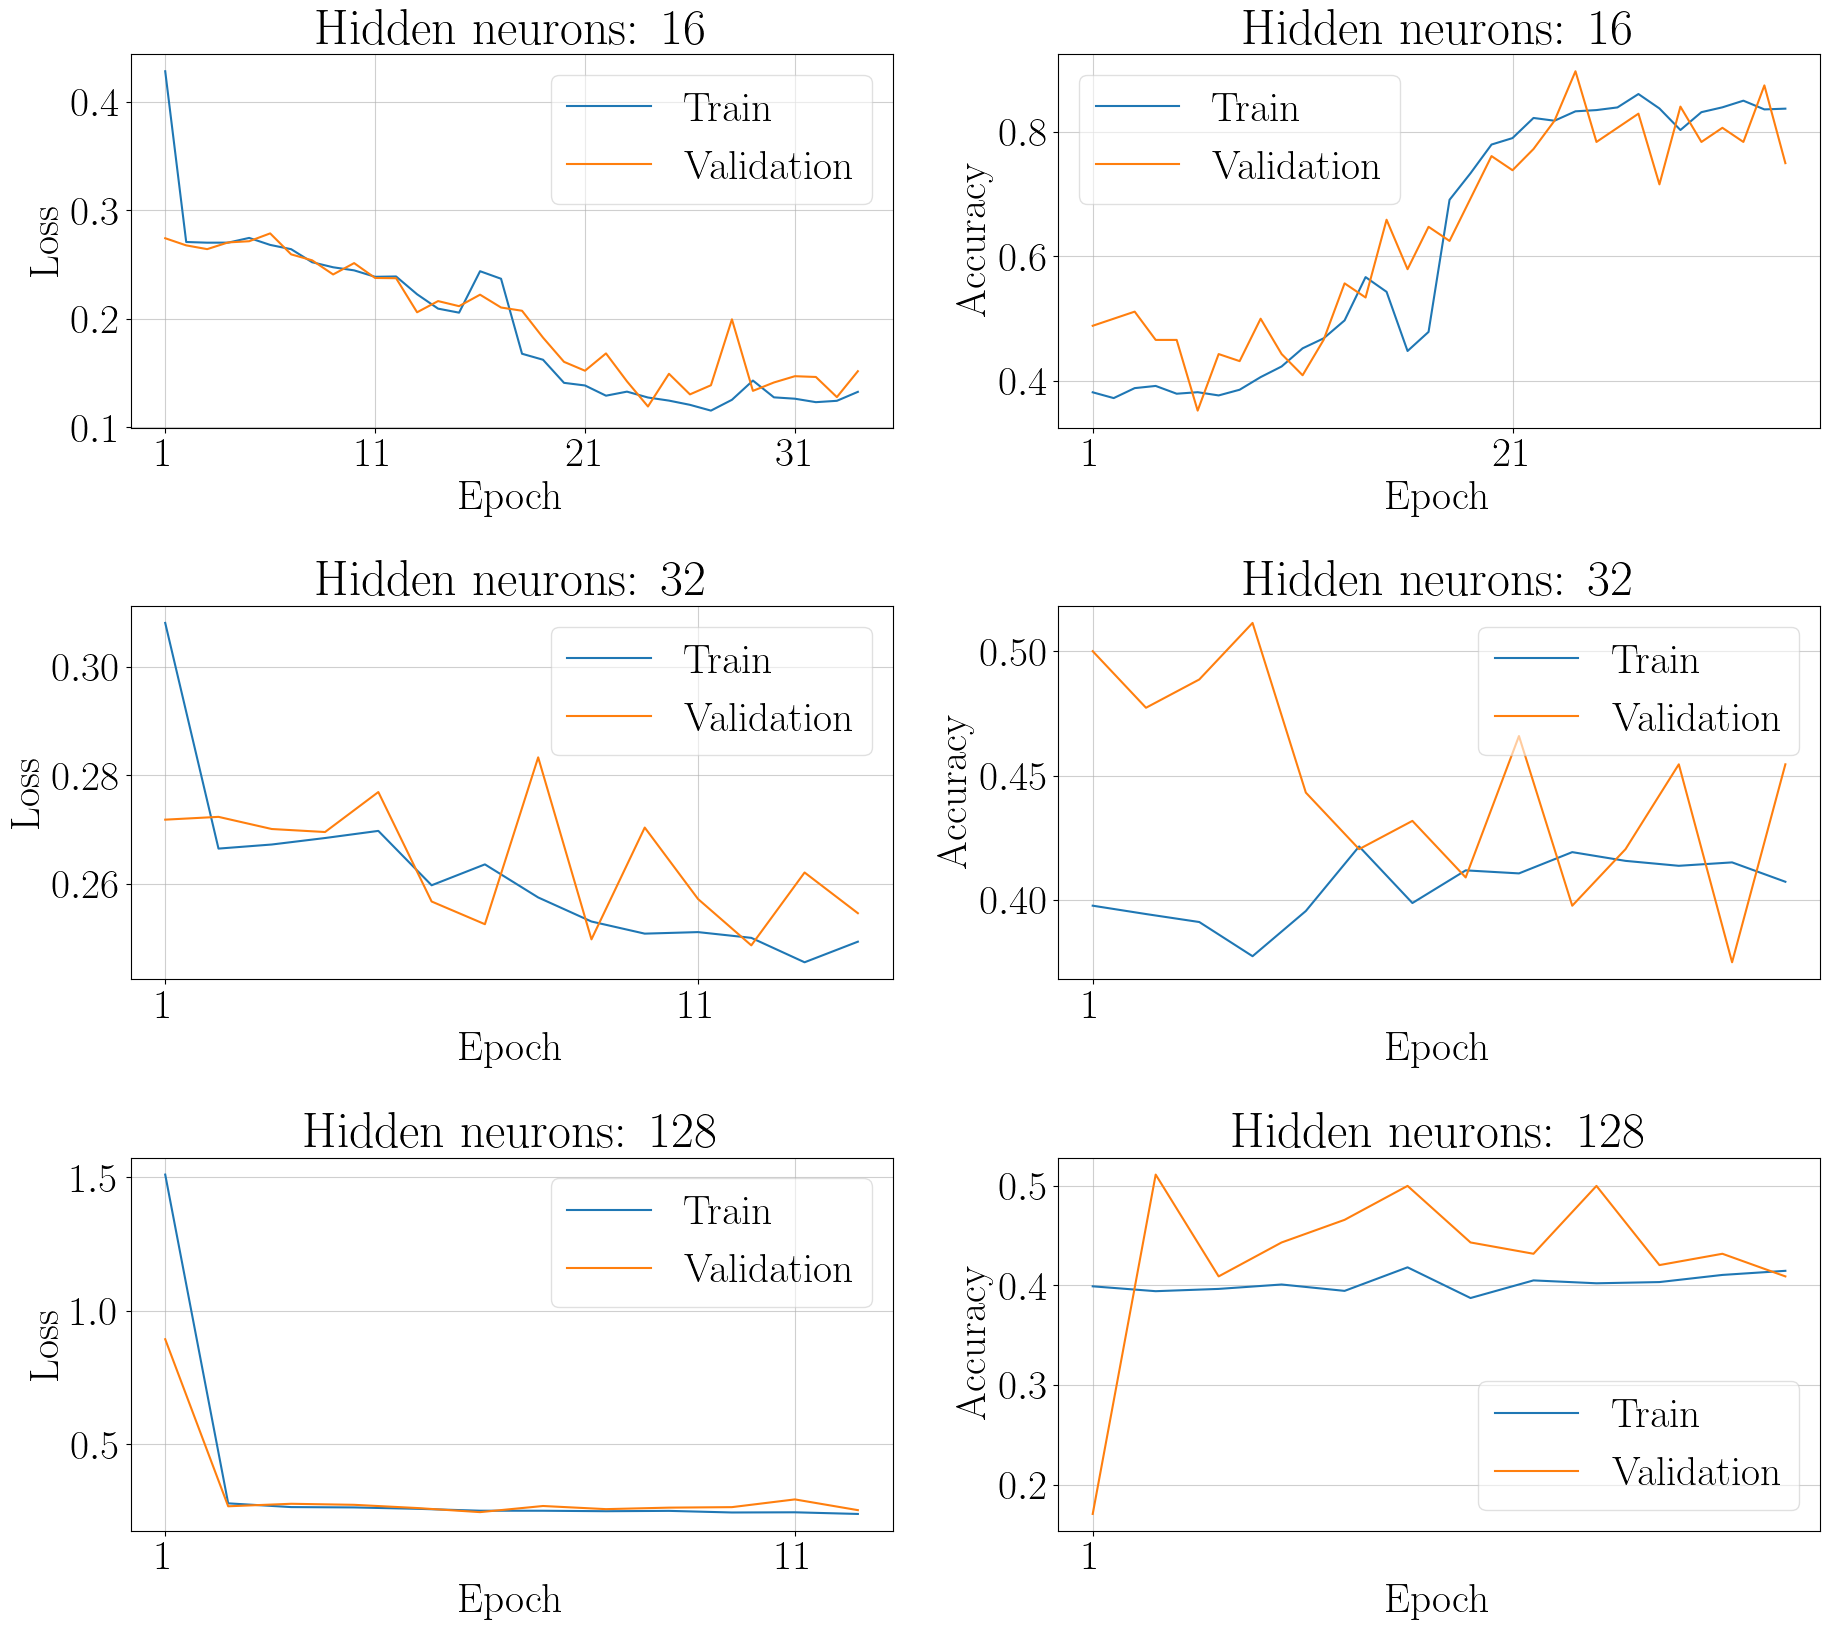

In [24]:
fig, axes = plt.subplots(3, 2, figsize=(19,17))

for i in range(len(hidden_neurons_sae)):
    train_loss, val_loss = train_loss_ls[i], val_loss_ls[i]
    train_acc,  val_acc = train_acc_ls[i], val_acc_ls[i]

    axes[i,0].plot(np.arange(1, len(train_loss)+1), train_loss, label='Train')
    axes[i,0].plot(np.arange(1, len(train_loss)+1), val_loss, label='Validation')
    axes[i,0].grid()
    axes[i,0].set_xlabel("Epoch")
    axes[i,0].set_ylabel("Loss")
    axes[i,0].set_xticks(np.arange(1, len(train_loss), 10))
    axes[i,0].set_title(f"Hidden neurons: {str(hidden_neurons_sae[i])}")
    axes[i,0].legend()

    axes[i,1].plot(np.arange(1, len(train_acc)+1), train_acc, label='Train')
    axes[i,1].plot(np.arange(1, len(val_acc)+1), val_acc, label='Validation')
    axes[i,1].grid()
    axes[i,1].set_xlabel("Epoch")
    axes[i,1].set_ylabel("Accuracy")
    axes[i,1].set_xticks(np.arange(1, len(train_acc), 20))
    axes[i,1].set_title(f"Hidden neurons: {str(hidden_neurons_sae[i])}")
    axes[i,1].legend()

plt.tight_layout()
plt.plot()


In [25]:
autoencoder = sae.sae_lin2(
                            input_dim = 64, 
                            hidden_dim = 16,
                            surr_grad = params_snn['surrogate_grad'],
                            learn_beta = params_snn['learn_beta'],
                            timesteps = N_WIN
                            ).to(device)

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    timesteps = N_WIN,
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE_1(autoencoder, classifier).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = params_train['l_rate'])

train_loss, val_loss, train_acc, val_acc = train_fn(
                                                model = net, 
                                                train = train_loader, 
                                                valid = val_loader,
                                                loss_fn_cae = params_cae['loss_fn'], 
                                                out_dec = params_snn['output_dec'],
                                                optimizer = optimizer, 
                                                acc_steps = params_train['acc_steps'],
                                                alpha = params_train['alpha'], 
                                                beta = params_train['beta'], 
                                                Lambda = params_train['lambda_reg'], 
                                                epochs = params_train['epochs'], 
                                                patience = params_train['patience'], 
                                                path = 'models/model_sae2.pt')

Epoch 1 - loss: 0.2682 | acc: 0.3977 | val_loss: 0.2717 | val_acc: 0.5114
Epoch 2 - loss: 0.2676 | acc: 0.3977 | val_loss: 0.2697 | val_acc: 0.5114
Epoch 3 - loss: 0.2664 | acc: 0.3979 | val_loss: 0.2697 | val_acc: 0.5114
Epoch 4 - loss: 0.264 | acc: 0.3977 | val_loss: 0.2448 | val_acc: 0.5114
Epoch 5 - loss: 0.2645 | acc: 0.398 | val_loss: 0.2696 | val_acc: 0.5114
Epoch 6 - loss: 0.2568 | acc: 0.3976 | val_loss: 0.2403 | val_acc: 0.5114
Epoch 7 - loss: 0.2416 | acc: 0.4266 | val_loss: 0.2267 | val_acc: 0.5227
Epoch 8 - loss: 0.2326 | acc: 0.5005 | val_loss: 0.2475 | val_acc: 0.4545
Epoch 9 - loss: 0.1804 | acc: 0.6024 | val_loss: 0.1924 | val_acc: 0.5682
Epoch 10 - loss: 0.185 | acc: 0.5975 | val_loss: 0.1746 | val_acc: 0.5455
Epoch 11 - loss: 0.1629 | acc: 0.6339 | val_loss: 0.1643 | val_acc: 0.6023
Epoch 12 - loss: 0.1513 | acc: 0.6705 | val_loss: 0.1697 | val_acc: 0.6364
Epoch 13 - loss: 0.15 | acc: 0.6803 | val_loss: 0.1773 | val_acc: 0.5909
Epoch 14 - loss: 0.1492 | acc: 0.6906 |

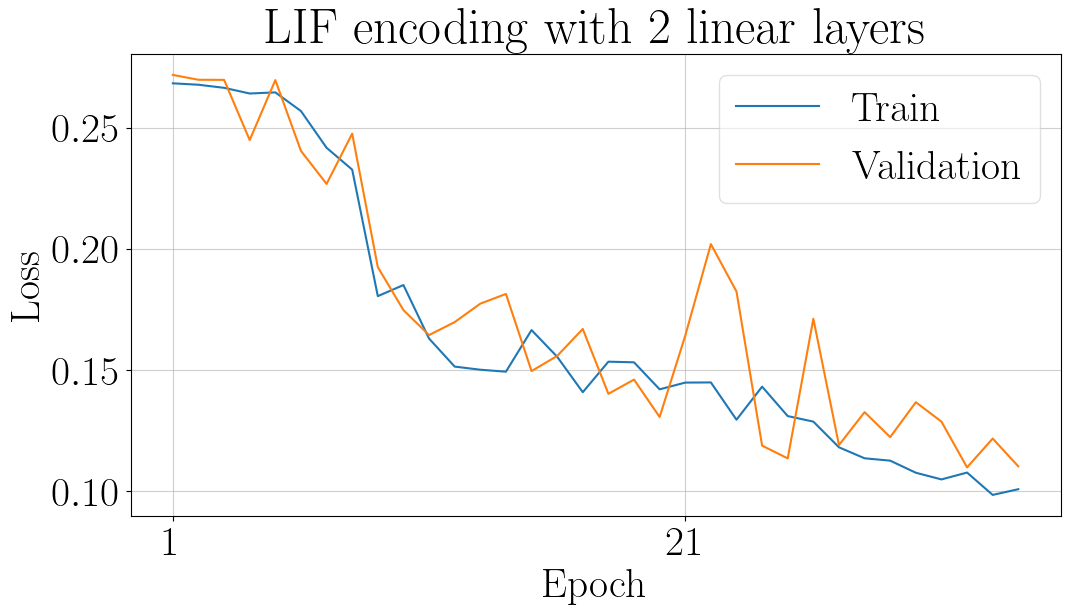

In [26]:
#plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Train')
plt.plot(np.arange(1, len(train_loss)+1), val_loss, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LIF encoding with 2 linear layers")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/LIF_enc/train_val_loss_1.png", bbox_inches='tight')
plt.show()

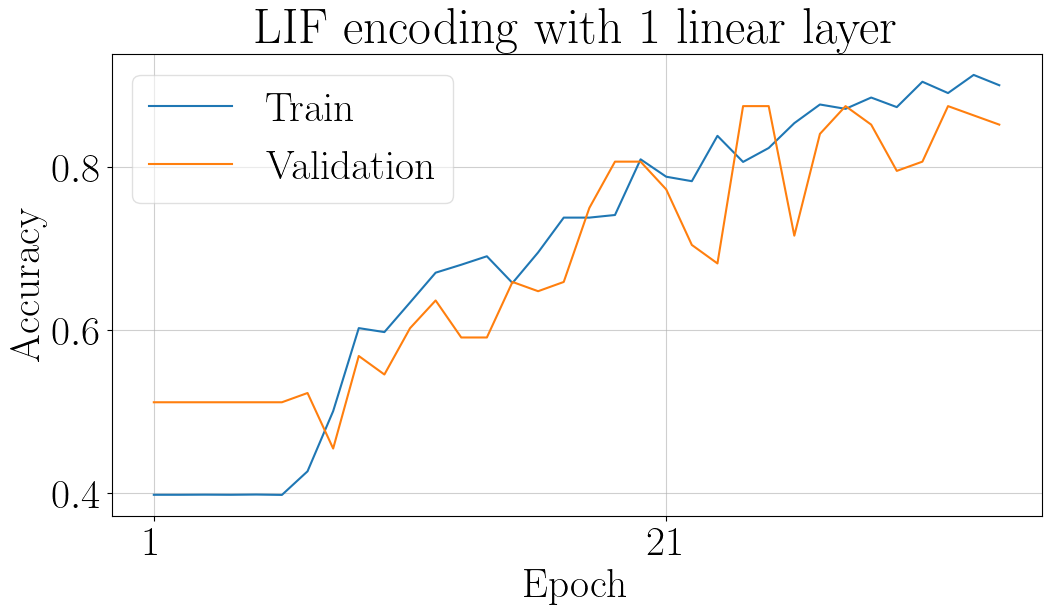

In [27]:
plt.plot(np.arange(1, len(train_acc)+1), train_acc, label='Train')
plt.plot(np.arange(1, len(train_acc)+1), val_acc, label='Validation')
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LIF encoding with 1 linear layer")
plt.xticks(np.arange(1, len(train_loss), 20))
plt.legend()
#plt.savefig("Plots/LIF_enc/train_val_acc.png", bbox_inches='tight')
plt.show()

In [28]:
path = "./models/model_sae2.pt"
autoencoder = sae.sae_lin2(
                        input_dim = 64, 
                        hidden_dim = 16,
                        surr_grad = params_snn['surrogate_grad'],
                        learn_beta = params_snn['learn_beta'],
                        timesteps = N_WIN
                        ).to(device)

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE_1(autoencoder, classifier).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE_1(
  (autoencoder): sae_lin2(
    (enc1): Linear(in_features=64, out_features=16, bias=True)
    (lif_enc1): Leaky()
    (enc2): Linear(in_features=16, out_features=64, bias=True)
    (lif_code): Leaky()
    (dec1): Linear(in_features=64, out_features=16, bias=True)
    (lif_dec1): Leaky()
    (dec2): Linear(in_features=16, out_features=64, bias=True)
    (sigmoid): Sigmoid()
  )
  (classifier): snn_1(
    (fc_in): Linear(in_features=1280, out_features=128, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=64, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [29]:
acc, prec, rec, f1, confusion_mx = evaluate(net, test_loader, 
                                            out_dec="rate", avg_type='macro',
                                            verbose=False)

acc_w, prec_w, rec_w, f1_2, confusion_mx_w = evaluate(net, test_loader, 
                                            out_dec="rate", avg_type='weighted')

AVERAGE TYPE: macro

Accuracy: 0.8764
Precision: 0.8789
Recall: 0.8391
F1 score: 0.852
AVERAGE TYPE: weighted

Accuracy: 0.8391
Precision: 0.8802
Recall: 0.8764
F1 score: 0.8725

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.88      0.96      0.92        46
     RUNNING       0.92      0.67      0.77        18
     SITTING       0.82      0.93      0.88        15
       HANDS       0.89      0.80      0.84        10

    accuracy                           0.88        89
   macro avg       0.88      0.84      0.85        89
weighted avg       0.88      0.88      0.87        89



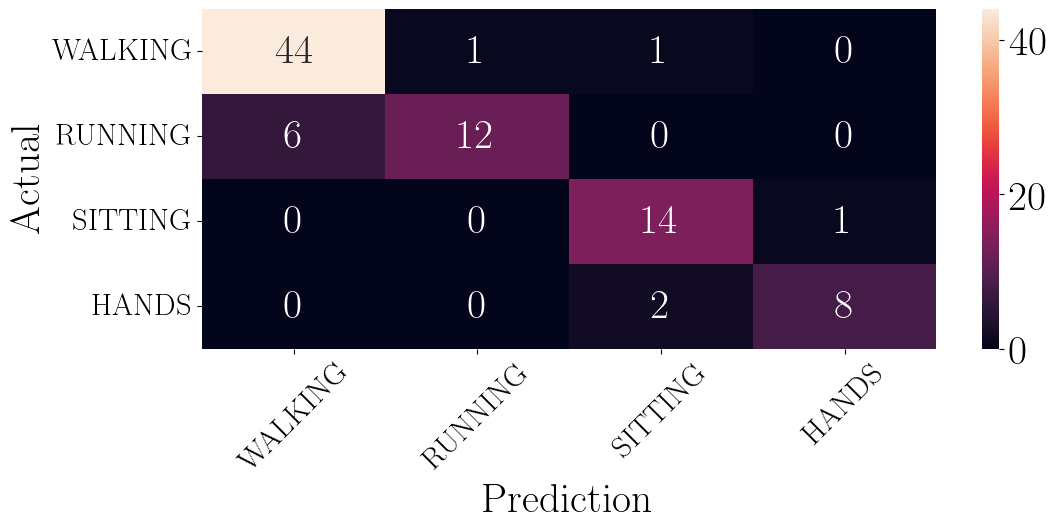

In [30]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/confusion_mx_macro_sae_lin.png", bbox_inches='tight')
plt.show()

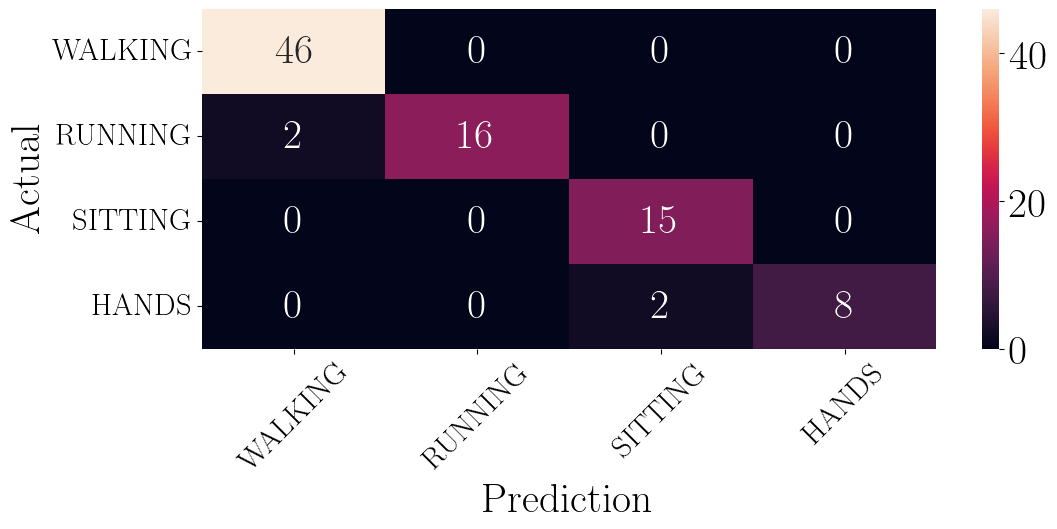

In [15]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/confusion_mx_macro_sae_lin.png", bbox_inches='tight')
plt.show()

## Encoding capacity

In [ ]:
class LSE_1(nn.Module):
    def __init__(self, autoencoder, classifier):
        super(LSE_1, self).__init__()
        self.autoencoder = autoencoder
        self.classifier = classifier

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.classifier(encoded)  
        return encoded, decoded, clss

In [16]:
path = "./models/model_opt_2.pt"
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE(
  (autoencoder): cae_3(
    (encoder): Sequential(
      (0): Conv3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Conv3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv3d(128, 2, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (4): BatchNorm3d(12

In [17]:
path = "./models/model_sae1.pt"
autoencoder = sae.sae_lin(
                        input_dim = 64, 
                        surr_grad = params_snn['surrogate_grad'],
                        learn_beta = params_snn['learn_beta'],
                        timesteps = N_WIN
                        ).to(device)

classifier =  network.snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net_1 = LSE_1(autoencoder, classifier).to(device)
net_1.load_state_dict(torch.load(path))
net_1.eval()

LSE_1(
  (autoencoder): sae_lin(
    (encoder): Linear(in_features=64, out_features=64, bias=True)
    (lif_code): Leaky()
    (decoder): Linear(in_features=64, out_features=64, bias=True)
    (sigmoid): Sigmoid()
  )
  (classifier): snn_1(
    (fc_in): Linear(in_features=1280, out_features=128, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=64, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [18]:
loss_fn = torch.nn.MSELoss()

loss_cae, loss_sae = 0, 0
sparsity_cae, sparsity_sae = [], [] 
shape_prod = 2*232*64*10

with torch.no_grad():
        for X, _, y in test_loader:
            X = X.to(device)

            encoded, decoded, spk_out = net(X.float())
            encoded1, decoded1, spk_out1 = net_1(X.float())

            loss_cae += loss_fn(decoded, X.float())
            loss_sae += loss_fn(decoded1, X.float())

            sparsity_cae.append((1-torch.sum(abs(encoded))/shape_prod).item())

            sparsity_sae.append((1-torch.sum(abs(encoded1))/shape_prod).item())
            
        loss_cae = loss_cae / len(test_loader)
        loss_sae = loss_sae / len(test_loader)

print(f"Reconstruction error of CAE: {round(loss_cae.item(), 4)}")
print(f"Reconstruction error of SAE: {round(loss_sae.item(), 4)}\n")
print(f"Average sparsity of CAE encoding: {round(np.mean(sparsity_cae), 4)}")
print(f"Average sparsity of SAE encoding: {round(np.mean(sparsity_sae), 4)}")

Reconstruction error of CAE: 0.0195
Reconstruction error of SAE: 0.0574

Average sparsity of CAE encoding: 0.7261
Average sparsity of SAE encoding: 0.9677


### Number of trainable parameters and weight of the model

In [19]:
print(f"# of trainable parameters of CAE: {utils_ext.count_params(net)}")
print(f"# of trainable parameters of SAE: {utils_ext.count_params(net_1)}\n")
print(f"Model size in MB of CAE: {utils_ext.model_size_in_mb(net)} MB")
print(f"Model size in MB of SAE: {utils_ext.model_size_in_mb(net_1)} MB")

# of trainable parameters of CAE: 343380
# of trainable parameters of SAE: 181256

Model size in MB of CAE: 1.31 MB
Model size in MB of SAE: 0.69 MB
